# Transfer Learning for Glacier Mass Balance Prediction

This notebook demonstrates **transfer learning** between glacier mass balance models trained on different regions. Specifically, we:

1. **Load a pre-trained neural network** trained on Swiss glacier data
2. **Fine-tune it on Norwegian glacier data** using various strategies
3. **Evaluate performance** on unseen Norwegian glaciers

## Key Features
- **Progressive layer unfreezing** for gradual adaptation
- **Multiple train/test split strategies** (50%, North/South, 5-10%)
- **Comprehensive evaluation metrics** and visualizations
- **Model checkpointing** at specific epochs for analysis

---

## Prerequisites
- Pre-trained model on all Swiss data from ../regions/Switzerland/3.2.2 Train-ML-model-NN.ipynb e.g. `nn_model_2025-07-14_CH_flexible.pt`
- Norwegian glacier dataset from ../regions/Norway_mb/1.1. Norway-prepro.ipynb
- ERA5 climate data of Norway from ../regions/Norway_mb/1.2. ERA5Land-prepro.ipynb

---

In [1]:
# Add root of repo to import MBM
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../'))

# Core libraries
import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
#import pickle # for displaying saved model parameters etc.
from datetime import datetime
from collections import defaultdict
import logging

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# Scientific computing
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Skorch (scikit-learn compatible PyTorch)
from skorch.helper import SliceDataset
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint

# MassBalanceMachine (custom package)
import massbalancemachine as mbm

# Local helper modules
from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

# Configure environment
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging for tracking progress
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Initialize configuration for Norwegian glaciers
cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')
print("Environment setup complete!")

Environment setup complete!


In [2]:
# Set random seeds for reproducibility
seed_all(cfg.seed)
free_up_cuda()

# Configure plotting style
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

# Define climate features from ERA5 reanalysis
vois_climate = [
    't2m',     # 2-meter temperature
    'tp',      # Total precipitation  
    'slhf',    # Surface latent heat flux
    'sshf',    # Surface sensible heat flux
    'ssrd',    # Surface solar radiation downwards
    'fal',     # Forecast albedo
    'str',     # Surface thermal radiation
    'u10',     # 10-meter U wind component
    'v10'      # 10-meter V wind component
]

# Define topographical features from OGGM
vois_topographical = [
    "aspect",                    # Terrain aspect (OGGM)
    "slope",                     # Terrain slope (OGGM)
    "hugonnet_dhdt",            # Ice thickness change (OGGM)
    "consensus_ice_thickness",   # Ice thickness consensus (OGGM)
    "millan_v",                 # Ice velocity (OGGM)
]

In [3]:
# Ensure reproducibility across runs
seed_all(cfg.seed)

# Check for CUDA availability and configure accordingly
if torch.cuda.is_available():
    print("CUDA is available - GPU acceleration enabled")
    free_up_cuda()
    
    # Uncomment to limit CPU usage during training:
    # torch.set_num_threads(2)
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available - using CPU only")

CUDA is available - GPU acceleration enabled


## Data Loading & Preprocessing

### Create Norwegian Glacier Dataset
We start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [4]:
# Load Norwegian glacier dataset with topographical features
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

# Remove entries with missing velocity data
data_wgms = data_wgms.dropna(subset=data_wgms.columns.drop('DATA_MODIFICATION'))

# Dataset summary
print('Dataset Overview:')
print(f'   Number of glaciers: {len(data_wgms["GLACIER"].unique())}')
print(f'   Total measurements: {len(data_wgms)}')
print('   Measurement breakdown:')
print(f'     Annual samples: {len(data_wgms[data_wgms.PERIOD == "annual"])}')
print(f'     Winter samples: {len(data_wgms[data_wgms.PERIOD == "winter"])}')
print(f'     Summer samples: {len(data_wgms[data_wgms.PERIOD == "summer"])}')

print(f'\nAvailable columns: {list(data_wgms.columns)}')

Dataset Overview:
   Number of glaciers: 31
   Total measurements: 5959
   Measurement breakdown:
     Annual samples: 3022
     Winter samples: 2937
     Summer samples: 0

Available columns: ['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER', 'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']


In [5]:
# Copy dataset for processing
data_NOR_test = data_wgms.copy()

# Define file paths for climate data integration
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

# Process or load preprocessed data
# Set RUN=True to reprocess data, False to load existing preprocessed file
RUN = False
print(f"{'Processing' if RUN else 'Loading'} monthly climate data...")

# Transform point measurements to monthly format and merge with ERA5 climate data
dataloader_gl = process_or_load_data(
                                    run_flag=RUN,
                                    df=data_NOR_test,
                                    paths=paths,
                                    cfg=cfg,
                                    vois_climate=vois_climate,
                                    vois_topographical=vois_topographical,
                                    output_file='NOR_dataset_monthly_full_with_millanv.csv'
                                    )

data_monthly_NOR = dataloader_gl.data
display(data_monthly_NOR.head(2))

Loading monthly climate data...


2025-09-29 13:19:41,866 - INFO - Loaded preprocessed data.
2025-09-29 13:19:41,867 - INFO - Number of monthly rows: 56965
2025-09-29 13:19:41,875 - INFO - Number of annual samples: 36350
2025-09-29 13:19:41,881 - INFO - Number of winter samples: 20615


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2013   16.04244   67.31103          -5.63        930.332494   
1  2013   16.04244   67.31103          -5.63        930.332494   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0             11.667506              942  RGI60-08.02384   
1             11.667506              942  RGI60-08.02384   

                                            POINT_ID  ID  ...   millan_v  \
0  Rundvassbreen_2013_annual_67.31103_16.04244_N_...   0  ...  69.698883   
1  Rundvassbreen_2013_annual_67.31103_16.04244_N_...   0  ...  69.698883   

        t2m        tp      slhf      sshf       ssrd       fal        str  \
0 -3.957367  0.002545 -120958.0  132238.0  2673505.0  0.518889 -2003158.0   
1 -7.107025  0.003408  107086.0  467112.0   414668.0  0.838310 -1135388.0   

        u10       v10  
0 -0.577771  0.414947  
1 -1.247729  1.351297  

[2 rows x 28 columns]

## Train/Test Split Strategies

Implement three different strategies for splitting the Norway data to test various transfer learning scenarios:

### Strategy 1: 50% Random Split (4 glaciers for fine-tuning)
**Data**: About 50 % of the available data is used as fine-tuning set, consisting of 4 glaciers, which have been chosen based on the different climactic regions of Norway

**Use case**: Balanced representation with good data availability for transfer learning adaptation.

In [6]:
# Fine-tuning glaciers (4 Norway glaciers to adapt Swiss model)
#train_glaciers = ['Engabreen', 'Nigardsbreen', 'Aalfotbreen', 'Graasubreen']

# 50% kmeans
train_glaciers = ['Engabreen',
 'Storglombreen N',
 'Moesevassbrea',
 'Blaaisen',
 'Blabreen',
 'Harbardsbreen',
 'Graasubreen',
 'Svelgjabreen',
 'Aalfotbreen',
 'Rundvassbreen',
 'Juvfonne',
 'Storsteinsfjellbreen',
 'Hansebreen',
 'Vesledalsbreen',
 'Vetlefjordbreen',
 'Blomstoelskardsbreen',
 'Vestre Memurubreen',
 'Austre Memurubreen']

# Test glaciers (all remaining Norway glaciers)
all_norway_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_norway_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Validate glacier names exist in dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")

# Use helper function from XGBoost to create test/train set. CV splits are not used here.
splits, test_set, train_set = get_CV_splits(
    dataloader_gl,
    test_split_on='GLACIER',
    test_splits=test_glaciers,
    random_state=cfg.seed
)
    
print(f'\nSplit Summary:')
print(f'   Train glaciers: ({len(train_set["splits_vals"])}) {train_set["splits_vals"]}')
print(f'   Test glaciers: ({len(test_set["splits_vals"])}) {test_set["splits_vals"]}')
print(f'   Train samples: {len(train_set["df_X"])}')
print(f'   Test samples: {len(test_set["df_X"])}')

Fine-tuning glaciers (18): ['Engabreen', 'Storglombreen N', 'Moesevassbrea', 'Blaaisen', 'Blabreen', 'Harbardsbreen', 'Graasubreen', 'Svelgjabreen', 'Aalfotbreen', 'Rundvassbreen', 'Juvfonne', 'Storsteinsfjellbreen', 'Hansebreen', 'Vesledalsbreen', 'Vetlefjordbreen', 'Blomstoelskardsbreen', 'Vestre Memurubreen', 'Austre Memurubreen']
Test glaciers (13): ['Nigardsbreen', 'Austdalsbreen', 'Hellstugubreen', 'Rembesdalskaaka', 'Svartisheibreen', 'Trollbergdalsbreen', 'Graafjellsbrea', 'Breidablikkbrea', 'Ruklebreen', 'Cainhavarre', 'Tunsbergdalsbreen', 'Hoegtuvbreen', 'Bondhusbrea']

Split Summary:
   Train glaciers: (18) ['Rundvassbreen' 'Engabreen' 'Aalfotbreen' 'Hansebreen' 'Juvfonne'
 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Vetlefjordbreen' 'Harbardsbreen'
 'Storglombreen N' 'Graasubreen' 'Blaaisen' 'Blabreen' 'Vesledalsbreen'
 'Austre Memurubreen' 'Vestre Memurubreen']
   Test glaciers: (13) ['Nigardsbreen' 'Austdalsbreen' 'Hellstugubreen' 'Rembe

### Strategy 2: North/South Geographic Split

**Data:** Southern glaciers are used as fine-tuning set, northern as test set. Split is based on the median latitude.

**Use case**: Test geographic generalization across latitudinal gradients and climatic zones.

In [6]:
# Calculate geographic split based on glacier latitudes
print("Strategy 2: North/South Geographic Split")

# Get glacier latitudes for geographic analysis
glacier_lat = data_wgms.groupby('GLACIER')['POINT_LAT'].first()

# Use the median latitude as the split threshold
#lat_threshold = glacier_lat.median()

# Use manually set cut off
lat_threshold = 63

# Split glaciers into northern and southern groups
north_glaciers = glacier_lat[glacier_lat >= lat_threshold].index.tolist()
south_glaciers = glacier_lat[glacier_lat < lat_threshold].index.tolist()

print(f"Latitude threshold: {lat_threshold:.2f}°")
print(f"North glaciers ({len(north_glaciers)}): {north_glaciers}")
print(f"South glaciers ({len(south_glaciers)}): {south_glaciers}")

Strategy 2: North/South Geographic Split
Latitude threshold: 63.00°
North glaciers (9): ['Blaaisen', 'Cainhavarre', 'Engabreen', 'Hoegtuvbreen', 'Rundvassbreen', 'Storglombreen N', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen']
South glaciers (22): ['Aalfotbreen', 'Austdalsbreen', 'Austre Memurubreen', 'Blabreen', 'Blomstoelskardsbreen', 'Bondhusbrea', 'Breidablikkbrea', 'Graafjellsbrea', 'Graasubreen', 'Hansebreen', 'Harbardsbreen', 'Hellstugubreen', 'Juvfonne', 'Moesevassbrea', 'Nigardsbreen', 'Rembesdalskaaka', 'Ruklebreen', 'Svelgjabreen', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']


In [7]:
# North/South Geographic Split: Train on southern glaciers (50% of data)
# This tests the model's ability to generalize across latitudinal climate gradients
"""
# Median split
train_glaciers = ['Austre Memurubreen', 'Blabreen', 'Blomstoelskardsbreen', 'Bondhusbrea', 
                    'Breidablikkbrea', 'Graafjellsbrea', 'Graasubreen', 'Hellstugubreen', 
                    'Moesevassbrea', 'Rembesdalskaaka', 'Ruklebreen', 'Svelgjabreen', 
                    'Tunsbergdalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']
"""
# 63 lat split
train_glaciers = ['Aalfotbreen', 'Austdalsbreen', 'Austre Memurubreen', 'Blabreen', 'Blomstoelskardsbreen',
                    'Bondhusbrea', 'Breidablikkbrea', 'Graafjellsbrea', 'Graasubreen', 'Hansebreen', 'Harbardsbreen',
                    'Hellstugubreen', 'Juvfonne', 'Moesevassbrea', 'Nigardsbreen', 'Rembesdalskaaka', 'Ruklebreen',
                    'Svelgjabreen', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']


# Test glaciers (northern glaciers with different climate characteristics)
all_norway_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_norway_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Validate glacier names exist in dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")

# Use helper function from XGBoost to create test/train set. CV splits are not used here.
splits, test_set, train_set = get_CV_splits(
    dataloader_gl,
    test_split_on='GLACIER',
    test_splits=test_glaciers,
    random_state=cfg.seed
)
    
print(f'\nSplit Summary:')
print(f'   Train glaciers: ({len(train_set["splits_vals"])}) {train_set["splits_vals"]}')
print(f'   Test glaciers: ({len(test_set["splits_vals"])}) {test_set["splits_vals"]}')
print(f'   Train samples: {len(train_set["df_X"])}')
print(f'   Test samples: {len(test_set["df_X"])}')

Fine-tuning glaciers (22): ['Aalfotbreen', 'Austdalsbreen', 'Austre Memurubreen', 'Blabreen', 'Blomstoelskardsbreen', 'Bondhusbrea', 'Breidablikkbrea', 'Graafjellsbrea', 'Graasubreen', 'Hansebreen', 'Harbardsbreen', 'Hellstugubreen', 'Juvfonne', 'Moesevassbrea', 'Nigardsbreen', 'Rembesdalskaaka', 'Ruklebreen', 'Svelgjabreen', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']
Test glaciers (9): ['Rundvassbreen', 'Engabreen', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Storglombreen N', 'Blaaisen', 'Cainhavarre', 'Hoegtuvbreen']

Split Summary:
   Train glaciers: (22) ['Aalfotbreen' 'Hansebreen' 'Nigardsbreen' 'Austdalsbreen' 'Juvfonne'
 'Hellstugubreen' 'Rembesdalskaaka' 'Svelgjabreen' 'Blomstoelskardsbreen'
 'Moesevassbrea' 'Vetlefjordbreen' 'Harbardsbreen' 'Graafjellsbrea'
 'Breidablikkbrea' 'Graasubreen' 'Blabreen' 'Ruklebreen'
 'Tunsbergdalsbreen' 'Vesledalsbreen' 'Austre Memurubreen'
 'Vestre Memurubreen' 'Bondhusbrea']
   Test gl

### Strategy 3: Limited Data Split (5-10% for fine-tuning)

**Data**: About 5-10 % of the available data is used as fine-tuning set, consisting of 7 glaciers, which have been chosen based on the different climactic regions of Norway

**Use case**: Test performance with minimal fine-tuning data (~500 measurements) to simulate data-scarce scenarios.

In [6]:
# TRANSFER LEARNING SETUP: 5-10% Limited Data Strategy

train_glaciers = [
    'Tunsbergdalsbreen',  
    'Austre Memurubreen', 
    'Svartisheibreen',    
    'Bondhusbrea',        
    'Harbardsbreen',      
    'Moesevassbrea',      
    'Graasubreen'         
]

# Test glaciers (majority of Norwegian glaciers)
all_norway_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_norway_glaciers if g not in train_glaciers]

print(f"Limited fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Validate glacier names exist in dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")

# Use helper function from XGBoost to create test/train set. CV splits are not used here.
splits, test_set, train_set = get_CV_splits(
    dataloader_gl,
    test_split_on='GLACIER',
    test_splits=test_glaciers,
    random_state=cfg.seed
)
    
print(f'\nSplit Summary:')
print(f'   Train glaciers: ({len(train_set["splits_vals"])}) {train_set["splits_vals"]}')
print(f'   Test glaciers: ({len(test_set["splits_vals"])}) {test_set["splits_vals"]}')
print(f'   Train samples: {len(train_set["df_X"])}')
print(f'   Test samples: {len(test_set["df_X"])}')

Limited fine-tuning glaciers (7): ['Tunsbergdalsbreen', 'Austre Memurubreen', 'Svartisheibreen', 'Bondhusbrea', 'Harbardsbreen', 'Moesevassbrea', 'Graasubreen']
Test glaciers (24): ['Rundvassbreen', 'Engabreen', 'Aalfotbreen', 'Hansebreen', 'Nigardsbreen', 'Austdalsbreen', 'Juvfonne', 'Hellstugubreen', 'Rembesdalskaaka', 'Svelgjabreen', 'Blomstoelskardsbreen', 'Storsteinsfjellbreen', 'Trollbergdalsbreen', 'Vetlefjordbreen', 'Storglombreen N', 'Graafjellsbrea', 'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre', 'Vesledalsbreen', 'Vestre Memurubreen', 'Hoegtuvbreen']

Split Summary:
   Train glaciers: (7) ['Moesevassbrea' 'Svartisheibreen' 'Harbardsbreen' 'Graasubreen'
 'Tunsbergdalsbreen' 'Austre Memurubreen' 'Bondhusbrea']
   Test glaciers: (24) ['Rundvassbreen' 'Engabreen' 'Aalfotbreen' 'Hansebreen' 'Nigardsbreen'
 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen' 'Rembesdalskaaka'
 'Svelgjabreen' 'Blomstoelskardsbreen' 'Storsteinsfjellbreen'
 'Trollbergdalsbreen' 'Vetl

## Validation Split Options

Use the same Option as was used for the Swiss model.

### Option 1: Random 80/20 Split
**Recommended for**: General model validation with balanced representation across all fine-tuning glaciers.

In [8]:
# Create random 80/20 train/validation split within the fine-tuning set
print("Creating random 80/20 train/validation split...")

# Combine training features with targets
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

# Create random train/validation split
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valdating dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

# Create training subset
df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Create validation subset
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

print("Split Results:")
print(f"   Train data glacier distribution: {df_X_train['GLACIER'].value_counts().head()}")
print(f"   Val data glacier distribution: {df_X_val['GLACIER'].value_counts().head()}")
print(f"   Train data shape: {df_X_train.shape}")
print(f"   Val data shape: {df_X_val.shape}")

Creating random 80/20 train/validation split...
Split Results:
   Train data glacier distribution: GLACIER
Nigardsbreen      11539
Aalfotbreen        6740
Hansebreen         2126
Graafjellsbrea     1918
Vesledalsbreen     1392
Name: count, dtype: int64
   Val data glacier distribution: GLACIER
Nigardsbreen      2694
Aalfotbreen       2022
Hansebreen         485
Graafjellsbrea     447
Vesledalsbreen     366
Name: count, dtype: int64
   Train data shape: (34595, 29)
   Val data shape: (8726, 29)


### Option 2: Glacier-wise Train/Val Split
**Recommended for**: Testing glacier-level generalization by validating on a completely unseen glacier during fine-tuning.

In [ ]:

data_train = train_set['df_X']
data_train['y'] = train_set['y']

val_glacier = ['Engabreen']
train_glaciers_subset = [g for g in train_glaciers if g not in val_glacier]

# Create training subset (excluding validation glacier)
df_X_train = data_train[data_train['GLACIER'].isin(train_glaciers_subset)].copy()
y_train = df_X_train['POINT_BALANCE'].values

# Create validation subset (only validation glacier)
df_X_val = data_train[data_train['GLACIER'].isin(val_glacier)].copy()
y_val = df_X_val['POINT_BALANCE'].values

print("Glacier-wise Split Results:")
print(f"   Training on: {train_glaciers_subset}")
print(f"   Validating on: {val_glacier}")
print(f"   Train data glacier distribution: {df_X_train['GLACIER'].value_counts().head()}")
print(f"   Val data glacier distribution: {df_X_val['GLACIER'].value_counts().head()}")
print(f"   Train data shape: {df_X_train.shape}")
print(f"   Val data shape: {df_X_val.shape}")

## Neural Network Configuration

### Feature Engineering and Dataset Preparation

In [9]:
# Define complete feature set for model training
features_topo = ['ELEVATION_DIFFERENCE'] + list(vois_topographical)

# Combine topographical and climate features
feature_columns = features_topo + list(vois_climate)

# Set features in config
cfg.setFeatures(feature_columns)

# Include all necessary columns (features + metadata)
all_columns = feature_columns + cfg.fieldsNotFeatures

# Create feature subsets (handle potential extra columns from Swiss data)
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Feature Configuration:')
print(f'   Training dataset shape: {df_X_train_subset.shape}')
print(f'   Validation dataset shape: {df_X_val_subset.shape}')
print(f'   Testing dataset shape: {df_X_test_subset.shape}')
print(f'   Features ({len(feature_columns)}): {feature_columns}')

# Sanity check: ensure targets match features
assert all(train_set['df_X'].POINT_BALANCE == train_set['y']), "Target mismatch detected!"
print('Feature-target alignment verified')

Feature Configuration:
   Training dataset shape: (34595, 28)
   Validation dataset shape: (8726, 28)
   Testing dataset shape: (13644, 28)
   Features (15): ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']
Feature-target alignment verified


### Model Callbacks and Training Configuration
Set up training callbacks and configuration for optimal performance and monitoring.

In [10]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='valid_loss',    # Monitor validation loss
    patience=15,             # Stop after 15 epochs without improvement
    threshold=1e-4,          # Minimum change threshold
)

# Learning rate scheduler for adaptive training
lr_scheduler_cb = LRScheduler(
    policy=ReduceLROnPlateau,
    monitor='valid_loss',
    mode='min',
    factor=0.5,              # Reduce LR by half
    patience=5,              # Wait 5 epochs before reducing
    threshold=0.01,
    threshold_mode='rel',
    verbose=True
)

# Global variables for dataset management
dataset = dataset_val = None

def my_train_split(ds, y=None, **fit_params):
    """Custom train/validation split function for skorch."""
    return dataset, dataset_val

# Model configuration parameters
param_init = {'device': 'cpu'}
nInp = len(feature_columns)  # Number of input features

# Model checkpointing to save best model during training
checkpoint_cb = Checkpoint(
    monitor='valid_loss_best',
    f_params='best_model.pt',
    f_optimizer=None,        # Don't save optimizer state
    f_history=None,          # Don't save training history
    f_criterion=None,        # Don't save criterion state
    load_best=True,          # Load best model after training
)

# Custom callback to save models at specific epochs for analysis
save_best_epochs_cb = SaveBestAtEpochs([10, 15, 20, 30, 50, 100])

print('Callbacks and configuration ready!')

Callbacks and configuration ready!


### Dataset Creation
Datasets will be created in the training loop after loading the pre-trained Swiss model to ensure compatible preprocessing.

In [11]:
# Initialize dataset variables as None
features = features_val = None
metadata = metadata_val = None
dataset = dataset_val = None

print("Dataset creation deferred until Swiss model is loaded...")

Dataset creation deferred until Swiss model is loaded...


## Transfer Learning Execution

### Loading Pre-trained Swiss Model and Fine-tuning on Norwegian Data

### Method 1: Standard Fine-tuning with Selective Layer Freezing

After loading the model, all layers will be frozen by default, to unfreeze a layer you have to include it in "if name not in [...]" in Step 3.

 The SaveBestAtEpochs callback automatically saves the current best model at epochs [10, 15, 20, 30, 50, 100], which can then be evaluated in the Epoch-wise model evalution section. Comment out the callback if you don't want this feature. If you do and you continuously want to retrain models at different learning rates, you have to reexecute the "save_best_epochs_cb = SaveBestAtEpochs([10, 15, 20, 30, 50, 100])" cell.

In [12]:
TRAIN = True  # Set to True to actually train, False to skip training

if TRAIN:
    print("Starting Method 1: Standard Fine-tuning with Layer Freezing")
    
    # STEP 1: Load the pre-trained Swiss model
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    # Define Swiss model architecture and parameters
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True,          # CRITICAL: preserve pretrained weights
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
            #('save_best_at_epochs', save_best_epochs_cb)  # Save models at specific epochs
        ]
    }
    
    # Load the pre-trained model
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )
    print("Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using Swiss model preprocessing
    print("Creating datasets with Swiss model preprocessing...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset_val, idx=0), 
                                                          SliceDataset(dataset_val, idx=1))
    
    print(f"Dataset shapes - Train: {dataset.X.shape}, Val: {dataset_val.X.shape}")

    # STEP 3: Apply selective layer freezing
    print("Applying selective layer freezing...")
    for name, param in loaded_model.module_.named_parameters():
        if name not in [#'model.0.weight', 'model.0.bias',
                        'model.1.weight', 'model.1.bias',
                        #'model.4.weight', 'model.4.bias',
                        'model.5.weight', 'model.5.bias',
                        #'model.8.weight', 'model.8.bias',
                        'model.9.weight', 'model.9.bias',
                        #'model.12.weight', 'model.12.bias',
                        'model.13.weight', 'model.13.bias',
                        #'model.16.weight', 'model.16.bias'
                        ]:
            param.requires_grad = False
    
    print("Layer freezing applied - batch norm and later layers remain trainable")
    
    # STEP 4: Configure for fine-tuning
    print("Configuring fine-tuning parameters...")
    loaded_model = loaded_model.set_params(
        lr=0.1,              
        max_epochs=1,
    )
    
    # STEP 5: Execute fine-tuning
    print("Starting fine-tuning process...")
    loaded_model.fit(features, y_train)
    
    # STEP 6: Save fine-tuned model
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"Fine-tuned model saved as: {finetuned_model_filename}")

Starting Method 1: Standard Fine-tuning with Layer Freezing
Loading pre-trained Swiss model...
Swiss model loaded successfully!
Creating datasets with Swiss model preprocessing...
Dataset shapes - Train: (3679,), Val: (920,)
Applying selective layer freezing...
Layer freezing applied - batch norm and later layers remain trainable
Configuring fine-tuning parameters...
Starting fine-tuning process...
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1        1.2629        0.8352     +  0.1000  1.7473
Fine-tuned model saved as: nn_model_finetuned_2025-09-29


### Method 2: Progressive Layer Unfreezing
This advanced approach gradually unfreezes layers during training for more controlled adaptation to the Norwegian data.

In [ ]:
TRAIN = False  # Set to True to execute progressive unfreezing

if TRAIN:
    print("Starting Method 2: Progressive Layer Unfreezing")
    
    # STEP 1: Load the pre-trained Swiss model
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    # Define Swiss model architecture (same as Method 1)
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True,          # CRITICAL: preserve pretrained weights
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
        ]
    }
    
    # Load the pre-trained model
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )
    print("Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using Swiss model preprocessing
    print("Creating datasets with Swiss model preprocessing...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset_val, idx=0), 
                                                          SliceDataset(dataset_val, idx=1))
    
    print(f"Dataset shapes - Train: {dataset.X.shape}, Val: {dataset_val.X.shape}")

    # STEP 3: Define progressive unfreezing strategy
    # Helper to freeze/unfreeze layers
    def set_requires_grad(layer_names, requires_grad=True):
        """Helper function to freeze/unfreeze specific layers"""
        for name, param in loaded_model.module_.named_parameters():
            if name in layer_names:
                param.requires_grad = requires_grad

    # Define layer groups for progressive unfreezing
    # Format: (layers_to_unfreeze, epochs, learning_rate)
    layer_groups = [
        # Stage 1: Unfreeze batch normalization layers first
        ([
            'model.1.weight', 'model.1.bias',
            'model.5.weight', 'model.5.bias',
            'model.9.weight', 'model.9.bias',
            'model.13.weight', 'model.13.bias'
        ], 200, 0.1),
        # Stage 2: Unfreeze output layer
        (['model.16.weight', 'model.16.bias'], 200, 0.001),
        # Stage 3: Unfreeze final hidden layer
        (['model.12.weight', 'model.12.bias'], 200, 0.001),
        # Stage 4: Unfreeze middle layer
        (['model.8.weight', 'model.8.bias'], 200, 0.001)
    ]

    # Start with all layers frozen
    print("Freezing all layers initially...")
    for name, param in loaded_model.module_.named_parameters():
        param.requires_grad = False

    # Progressive unfreezing loop
    for i, (layers, epochs, lr) in enumerate(layer_groups, 1):
        print(f"Stage {i}: Unfreezing {len(layers)//2} layer(s) for {epochs} epochs (lr={lr})...")
        
        # Unfreeze current layer group
        set_requires_grad(layers, True)
        
        # Update model parameters
        loaded_model = loaded_model.set_params(lr=lr, max_epochs=epochs)
        
        # Train current stage
        loaded_model.fit(features, y_train)
        
        # Evaluate current stage
        val_score = loaded_model.score(dataset_val.X, dataset_val.y)
        print(f"   Stage {i} validation score: {val_score:.4f}")
    
    # STEP 4: Save progressively fine-tuned model
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_progressive_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"Progressively fine-tuned model saved as: {finetuned_model_filename}")

else:
    print("Progressive training skipped (TRAIN=False)")

### Model Evaluation

#### Quick Performance Evaluation
Get immediate performance metrics on the test set using the fine-tuned model.

In [13]:
# Quick comprehensive evaluation of the fine-tuned model
print("Evaluating fine-tuned model performance...")

grouped_ids, scores_NN, ids_NN, y_pred_NN = evaluate_model_and_group_predictions(
    loaded_model, df_X_test_subset, test_set['y'], cfg, mbm
)

print("Test Set Performance Metrics:")
display(scores_NN)

# Validation score for confirmation that model with the best val_loss is used
val_score = loaded_model.score(dataset_val.X, dataset_val.y)
print(f"Validation score (for reference): {val_score:.4f}")

# Calculate additional performance metrics by glacier
print("\nPerformance by glacier:")
glacier_performance = grouped_ids.groupby('GLACIER').apply(
    lambda x: pd.Series({
        'n_samples': len(x),
        'rmse': np.sqrt(np.mean((x['target'] - x['pred'])**2)),
        'mae': np.mean(np.abs(x['target'] - x['pred'])),
        'r2': 1 - np.sum((x['target'] - x['pred'])**2) / np.sum((x['target'] - x['target'].mean())**2)
    })
).round(4)

display(glacier_performance.sort_values('rmse'))

Evaluating fine-tuned model performance...
Test Set Performance Metrics:


{'score': -1.0830223028752524,
 'mse': 1.0830223110333321,
 'rmse': 1.0406835787276227,
 'mae': 0.794915961376008,
 'pearson': 0.8771111666546481}

Validation score (for reference): -0.8352

Performance by glacier:


n_samples    rmse     mae      r2
GLACIER                                                
Hoegtuvbreen              104.0  0.7051  0.5633  0.8259
Trollbergdalsbreen        108.0  0.7951  0.6334  0.7663
Blaaisen                  178.0  0.8251  0.5885  0.4980
Cainhavarre                52.0  0.8378  0.7187  0.2189
Storglombreen N            27.0  0.8402  0.6804  0.7810
Svartisheibreen            83.0  0.8870  0.6697  0.7953
Rundvassbreen             127.0  0.9214  0.7556  0.7456
Storsteinsfjellbreen      322.0  1.0886  0.9338  0.0171
Engabreen                 359.0  1.3158  0.9509  0.8039

#### Epoch-wise Model Evaluation
Evaluate models saved at different training epochs to understand training dynamics and optimal stopping points.

In [14]:
# Evaluate models saved at different epochs to analyze training dynamics
print("Evaluating models saved at different training epochs...")

epochs_to_evaluate = [10, 15, 20, 30, 50, 100]
model_prefix = "nn_model_best_epoch"

epoch_results = {}

for epoch in epochs_to_evaluate:
    model_name = f"{model_prefix}_{epoch}.pt"
    
    # Check if model file exists
    if not os.path.exists(model_name):
        print(f"Model for epoch {epoch} not found, skipping...")
        continue

    print(f"Evaluating model at epoch {epoch}...")
    
    # Load model with same architecture as Swiss model
    epoch_model = mbm.models.CustomNeuralNetRegressor(
        cfg, **swiss_args, **param_init
    )
    epoch_model = epoch_model.set_params(device='cpu').to('cpu')
    epoch_model.initialize()
    
    # Load saved weights
    state_dict = torch.load(model_name, map_location='cpu')
    epoch_model.module_.load_state_dict(state_dict)

    # Evaluate the model
    grouped_ids_epoch, scores_NN_epoch, ids_NN_epoch, y_pred_NN_epoch = evaluate_model_and_group_predictions(
        epoch_model, df_X_test_subset, test_set['y'], cfg, mbm
    )
    
    # Store results
    epoch_results[epoch] = scores_NN_epoch
    
    print(f"Epoch {epoch} performance:")
    display(scores_NN_epoch)
    print("-" * 50)

print("Epoch-wise evaluation completed!")

# Compare performance across epochs
if epoch_results:
    print("\nPerformance comparison across epochs:")
    comparison_df = pd.DataFrame(epoch_results).T
    comparison_df.index.name = 'Epoch'
    display(comparison_df.round(4))

Evaluating models saved at different training epochs...
Model for epoch 10 not found, skipping...
Model for epoch 15 not found, skipping...
Model for epoch 20 not found, skipping...
Model for epoch 30 not found, skipping...
Model for epoch 50 not found, skipping...
Model for epoch 100 not found, skipping...
Epoch-wise evaluation completed!


#### Comprehensive Visualization and Analysis
Generate detailed visualizations to understand model performance across different glaciers and time periods.

In [15]:
# Prepare comprehensive visualization data
print("Preparing data for comprehensive visualizations...")

# Create features and metadata for final evaluation
features_test, metadata_test = loaded_model._create_features_metadata(df_X_test_subset)

# Ensure all tensors are on CPU for visualization
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()
if hasattr(test_set['y'], 'cpu'):
    targets_test = test_set['y'].cpu()
else:
    targets_test = test_set['y']

# Create final test dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),  # Features
    SliceDataset(dataset_test, idx=1)   # Targets
]

# Generate final predictions
print("Generating final predictions for visualization...")
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

# Prepare evaluation metrics
batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate comprehensive performance metrics
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

print(f"Final Model Performance Summary:")
print(f"   R² Score: {score:.4f}")
print(f"   RMSE: {rmse:.4f} mm w.e.")
print(f"   MAE: {mae:.4f} mm w.e.")
print(f"   Pearson r: {pearson:.4f}")

# Create comprehensive results DataFrame
id = dataset_test[0].dataset.indexToId(batchIndex)
grouped_ids = pd.DataFrame({
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
})

# Add comprehensive metadata
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

print("Visualization data prepared successfully!")

Preparing data for comprehensive visualizations...
Generating final predictions for visualization...
Final Model Performance Summary:
   R² Score: -1.0830
   RMSE: 1.0407 mm w.e.
   MAE: 0.7949 mm w.e.
   Pearson r: 0.8771
Visualization data prepared successfully!


In [16]:
from matplotlib.ticker import MaxNLocator
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams.update({
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'axes.edgecolor': 'black',
        'figure.edgecolor': 'black'
    })

Creating comprehensive visualizations...
   Generating time series predictions by glacier...
   Creating prediction vs. truth scatter plot...
   Generating individual glacier performance analysis...
All visualizations generated successfully!

Detailed Performance Summary by Glacier:
Performance by glacier (sorted by RMSE):


N_samples    RMSE     MAE      R²  Target_mean  \
GLACIER                                                                
Hoegtuvbreen                104  0.7051  0.5633  0.8259       1.9032   
Trollbergdalsbreen          108  0.7951  0.6334  0.7663       0.8719   
Blaaisen                    178  0.8251  0.5885  0.4980       0.7280   
Cainhavarre                  52  0.8378  0.7187  0.2189       0.5598   
Storglombreen N              27  0.8402  0.6804  0.7810       0.6622   
Svartisheibreen              83  0.8870  0.6697  0.7953       0.7281   
Rundvassbreen               127  0.9214  0.7556  0.7456       0.3480   
Storsteinsfjellbreen        322  1.0886  0.9338  0.0171       0.6617   
Engabreen                   359  1.3158  0.9509  0.8039       0.7287   

                      Target_std  
GLACIER                           
Hoegtuvbreen              1.6981  
Trollbergdalsbreen        1.6523  
Blaaisen                  1.1678  
Cainhavarre               0.9572  
Storglombreen N           1.8294  
Svartisheibreen           1.9723  
Rundvassbreen             1.8339  
Storsteinsfjellbreen      1.0997  
Engabreen                 2.9757

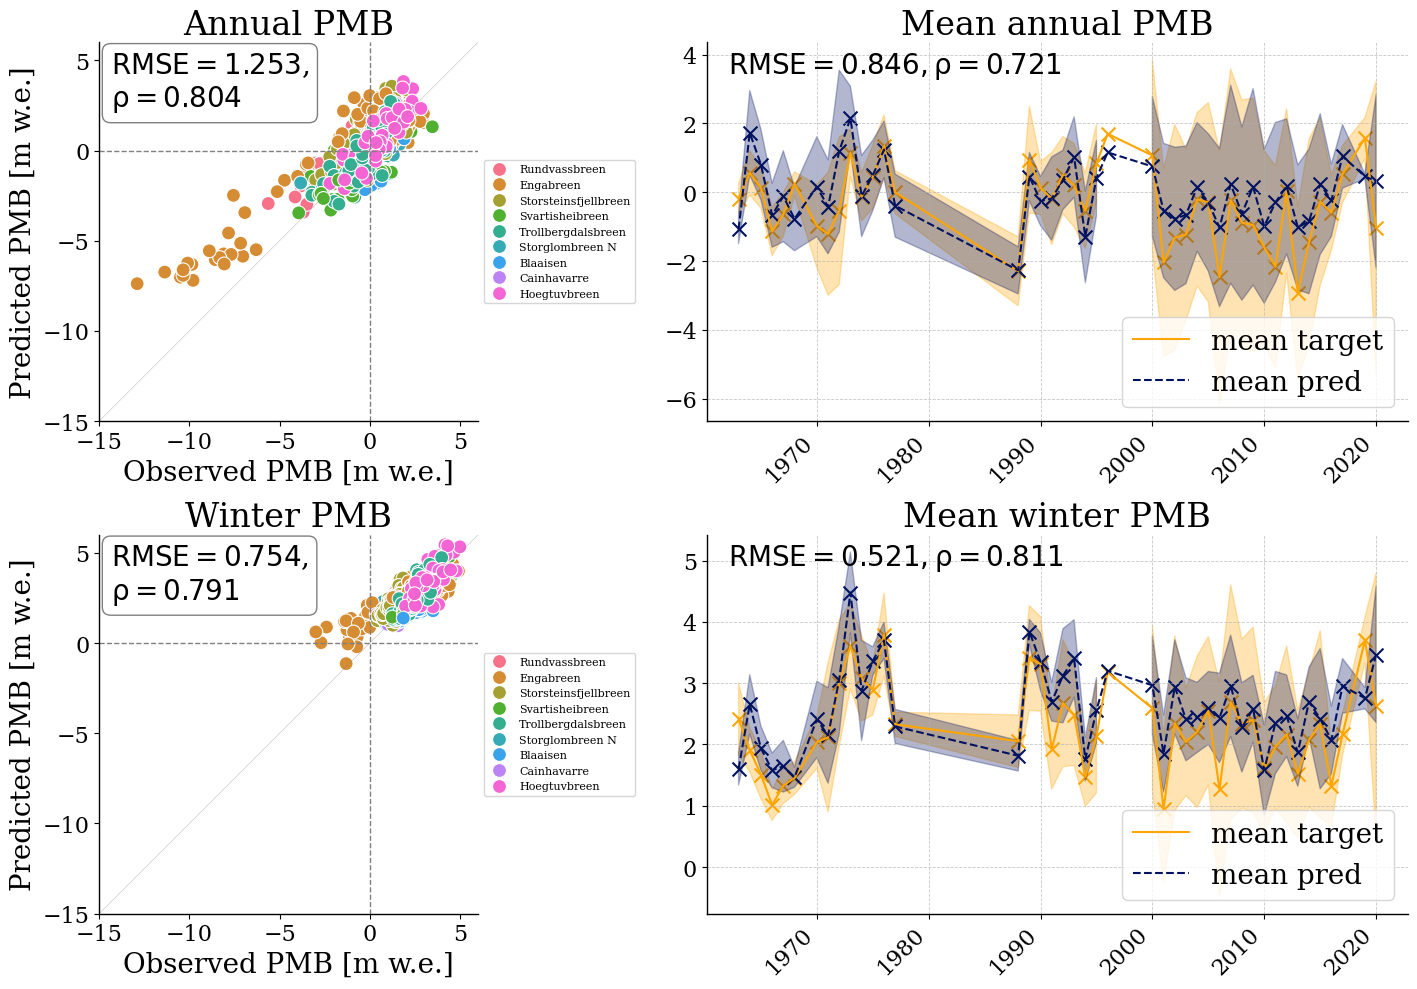

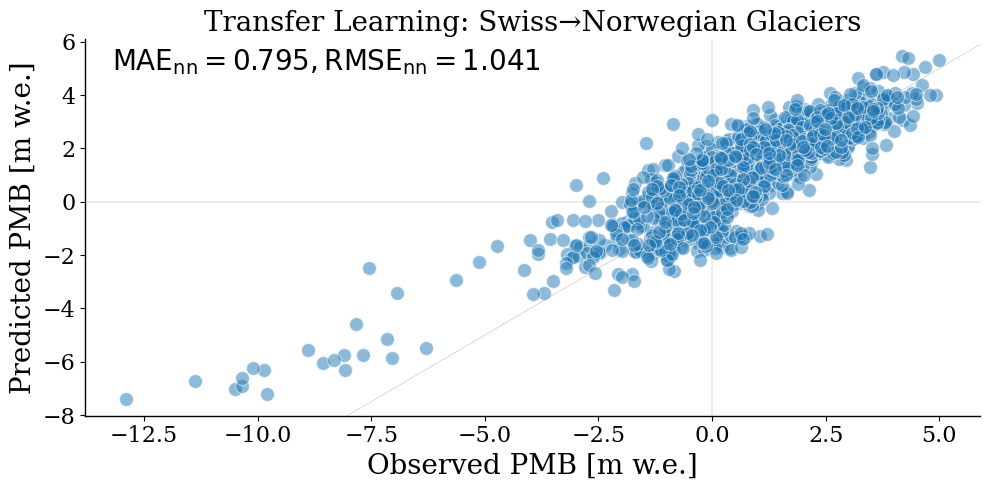

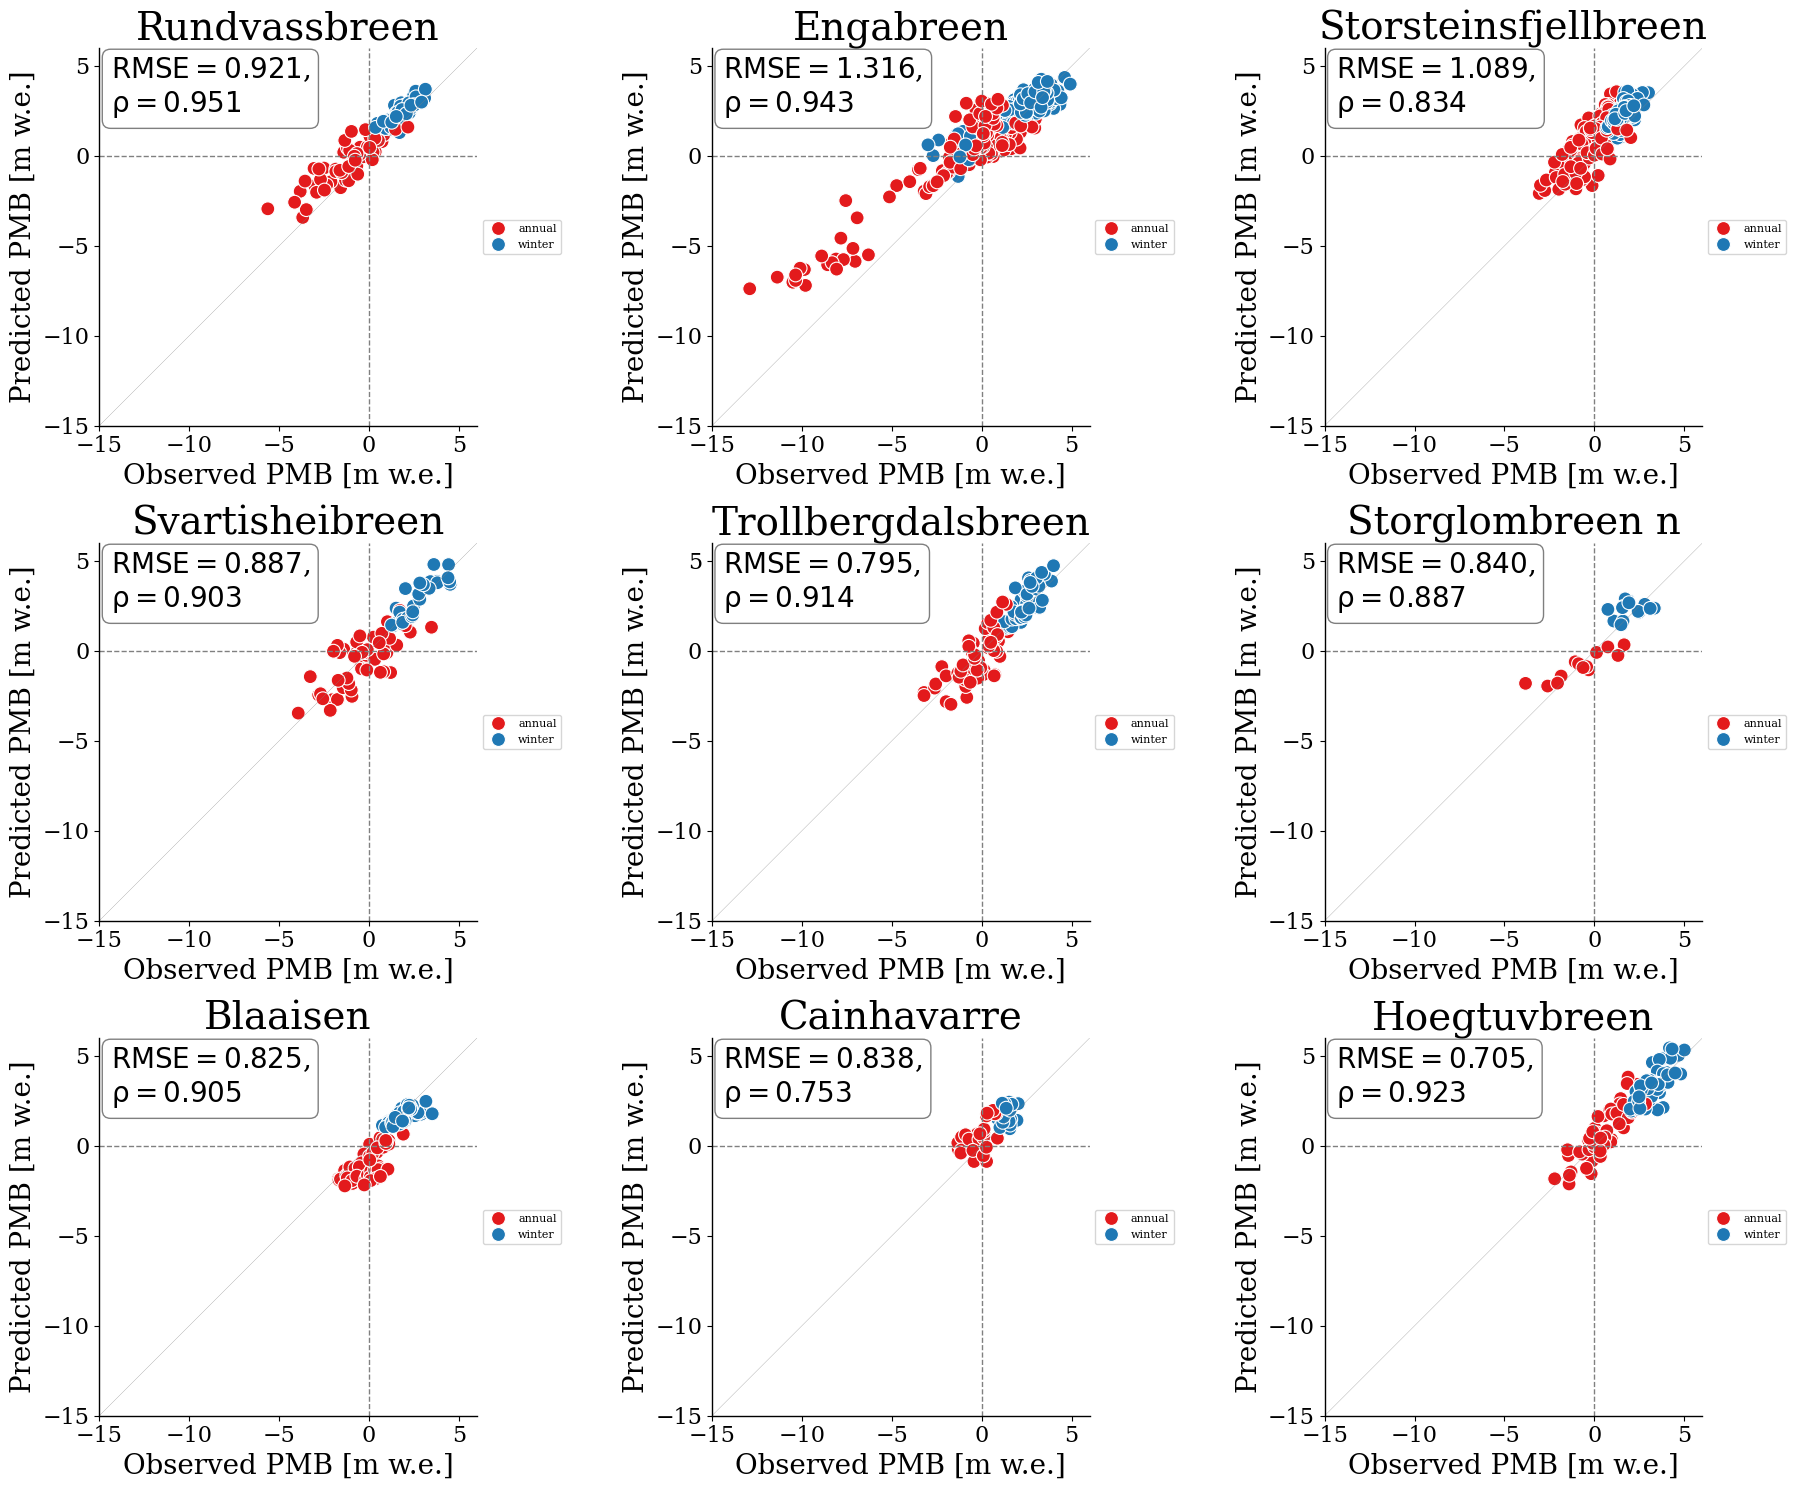

In [17]:
# Generate comprehensive publication-ready visualizations
print("Creating comprehensive visualizations...")

# 1. Time series predictions by glacier
print("   Generating time series predictions by glacier...")
PlotPredictions_NN(grouped_ids)

# 2. Predicted vs. observed scatter plot with performance metrics
print("   Creating prediction vs. truth scatter plot...")
predVSTruth_all(grouped_ids, mae, rmse, title='Transfer Learning: Swiss→Norwegian Glaciers')

# 3. Individual glacier performance analysis
print("   Generating individual glacier performance analysis...")
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

print("All visualizations generated successfully!")

# Summary statistics by glacier for detailed analysis
print("\nDetailed Performance Summary by Glacier:")
glacier_stats = grouped_ids.groupby('GLACIER').agg({
    'target': ['count', 'mean', 'std'],
    'pred': ['mean', 'std']
}).round(4)

# Calculate RMSE and MAE per glacier
glacier_rmse = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.sqrt(np.mean((x['target'] - x['pred'])**2))
).round(4)

glacier_mae = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.mean(np.abs(x['target'] - x['pred']))
).round(4)

glacier_r2 = grouped_ids.groupby('GLACIER').apply(
    lambda x: 1 - np.sum((x['target'] - x['pred'])**2) / np.sum((x['target'] - x['target'].mean())**2)
).round(4)

# Combine all metrics
performance_summary = pd.DataFrame({
    'N_samples': glacier_stats[('target', 'count')],
    'RMSE': glacier_rmse,
    'MAE': glacier_mae,
    'R²': glacier_r2,
    'Target_mean': glacier_stats[('target', 'mean')],
    'Target_std': glacier_stats[('target', 'std')]
}).sort_values('RMSE')

print("Performance by glacier (sorted by RMSE):")
display(performance_summary)

##### Visualization of all model strategies

In [ ]:
# DANN components: Gradient Reversal, network, regressor wrapper, and dataset bindings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skorch.utils import to_tensor
import massbalancemachine as mbm
from pathlib import Path

# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GradReverse(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

class DANNNetwork(nn.Module):
    """
    Feature extractor identical to FlexibleNetwork's trunk, with two heads:
    - Regressor head for SMB (label)
    - Domain classifier head (binary)
    """
    def __init__(self, input_dim, hidden_layers, dropout=0.2, use_batchnorm=False, domain_hidden=64, grl_lambda=1.0):
        super().__init__()
        layers = []
        current_dim = input_dim
        if not isinstance(dropout, list):
            dropout = [dropout] * len(hidden_layers)
        for hidden_dim, drop_rate in zip(hidden_layers, dropout):
            layers.append(nn.Linear(current_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            current_dim = hidden_dim
        # trunk outputs the last hidden representation
        self.feature_extractor = nn.Sequential(*layers)
        # heads
        self.regressor = nn.Linear(current_dim, 1)
        self.grl = GradReverse(lambda_=grl_lambda)
        self.domain_classifier = nn.Sequential(
            nn.Linear(current_dim, domain_hidden),
            nn.ReLU(),
            nn.Dropout(dropout[-1] if isinstance(dropout, list) else dropout),
            nn.Linear(domain_hidden, 1),  # logits
        )

    def forward(self, x):
        h = self.feature_extractor(x)
        y_pred = self.regressor(h)
        d_logits = self.domain_classifier(self.grl(h))
        return y_pred, d_logits

# Dataset that yields domain labels padded per ID to match monthly padding
class DomainTargetDataset(torch.utils.data.Dataset):
    def __init__(self, aggregated_dataset):
        self.base = aggregated_dataset
        self.meta_has_domain = 'DOMAIN' in self.base.metadataColumns
        if not self.meta_has_domain:
            # fallback: try to read from features
            assert 'DOMAIN' in self.base.cfg.featureColumns, "DOMAIN must be in metadata or featureColumns"
            self.domain_feat_idx = self.base.cfg.featureColumns.index('DOMAIN')
        else:
            self.domain_idx = self.base.metadataColumns.index('DOMAIN')
    def __len__(self):
        return len(self.base)
    def __getitem__(self, index):
        ind = self.base._getInd(index)
        if self.meta_has_domain:
            dval = self.base.metadata[ind[0]][self.domain_idx]
        else:
            dval = self.base.features[ind[0], self.domain_feat_idx]
        dpad = np.empty(self.base.maxConcatNb, dtype=np.float32)
        dpad.fill(np.nan)
        dpad[:len(ind)] = dval
        return dpad

# Binding that returns (X, (y, d)) so y_true in get_loss can contain both
class CombinedTargetBinding(torch.utils.data.Dataset):
    def __init__(self, X_slice, y_slice, d_dataset):
        self.X = X_slice
        self.y = y_slice
        self.d = d_dataset
        assert len(self.X) == len(self.y) == len(self.d)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], (self.y[idx], self.d[idx])

# Skorch regressor that adds domain-adversarial loss on top of the SMB loss
class CustomDANNRegressor(mbm.models.CustomNeuralNetRegressor):
    def __init__(self, cfg, *args, dan_lambda=0.1, **kwargs):
        super().__init__(cfg, *args, **kwargs)
        self.dan_lambda = dan_lambda
        self._last_domain_logits = None

    def infer(self, x, **fit_params):
        x = to_tensor(x, device=self.device)
        if len(x.shape) == 1:
            x = x[None]
        x, indNonNan = self._unpack_inp(x)
        if self.modelDtype is not None:
            x = x.type(self.modelDtype)
        outputs = self.module_(x, **fit_params)
        if isinstance(outputs, tuple):
            y_monthly, d_monthly = outputs
            y_packed = self._pack_out(y_monthly, indNonNan)
            d_packed = self._pack_out(d_monthly, indNonNan)
            self._last_domain_logits = d_packed
            return y_packed
        else:
            return self._pack_out(outputs, indNonNan)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        # y_true can be (label_pad, domain_pad) from CombinedTargetBinding
        if isinstance(y_true, (tuple, list)) and len(y_true) == 2:
            y_true_labels, y_true_domain = y_true
        else:
            y_true_labels, y_true_domain = y_true, None

        # Label loss (same as base implementation)
        loss = 0.0
        cnt = 0
        for yi_pred, yi_true in zip(y_pred, y_true_labels):
            valid = ~torch.isnan(yi_pred)
            if valid.any():
                pred_sum = yi_pred[valid].sum()
                true_mean = yi_true[valid].mean()
                loss = loss + (pred_sum - true_mean) ** 2
                cnt += 1
        label_loss = loss / max(cnt, 1)

        # Domain loss (optional during training)
        """"
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits
            mask = ~torch.isnan(y_true_domain)
            if mask.any():
                domain_loss = F.binary_cross_entropy_with_logits(d_logits[mask], y_true_domain[mask].float())
        """
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean, otherwise IDs with longer months have higher domain loss
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # shape: [batch, max_months] (or [batch, max_months, 1])
            per_id_losses = []
            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                # squeeze trailing dim if present
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                # mask valid months
                mask = ~torch.isnan(d_true_row) # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    per_id_losses.append(loss_i)

            if len(per_id_losses) > 0:
                domain_loss = torch.stack(per_id_losses).mean()  # mean over IDs
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean for each domain
        # otherwise IDs with longer months have higher domain loss and CH domain loss with more data is exaggerated
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # [batch_ids, max_months(,1)]
            per_id_losses_ch, per_id_losses_nor = [], []

            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                mask = ~torch.isnan(d_true_row)  # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    # domain for this ID (same across valid months)
                    dom_i = int(d_true_row[mask][0].item())  # 0=CH, 1=NOR
                    (per_id_losses_ch if dom_i == 0 else per_id_losses_nor).append(loss_i)

            parts = []
            if len(per_id_losses_ch) > 0:
                parts.append(torch.stack(per_id_losses_ch).mean())
            if len(per_id_losses_nor) > 0:
                parts.append(torch.stack(per_id_losses_nor).mean())
            if len(parts) > 0:
                domain_loss = torch.stack(parts).mean()

        return label_loss + self.dan_lambda * domain_loss

    @staticmethod
    def load_model(cfg, fname: str, *args, **kwargs):
        """Loads a pre-trained DANN model from a file."""
        model = CustomDANNRegressor(cfg, *args, **kwargs)
        model.initialize()
        models_dir = Path("./models")
        model.load_params(f_params=models_dir / fname)
        return model

params_dann = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
    'module__domain_hidden': 64,
    'module__grl_lambda': 1.0,
}

# Use DANN network
args_dann = {
    'module': DANNNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params_dann['module__dropout'],
    'module__hidden_layers': params_dann['module__hidden_layers'],
    'module__use_batchnorm': params_dann['module__use_batchnorm'],
    'module__domain_hidden': params_dann['module__domain_hidden'],
    'module__grl_lambda': params_dann['module__grl_lambda'],
    'train_split': my_train_split,
    'batch_size': params_dann['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params_dann['lr'],
    'max_epochs': 200,
    'optimizer': params_dann['optimizer'],
    'optimizer__weight_decay': params_dann['optimizer__weight_decay'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

Loading Norwegian baseline: nn_model_2025-08-26_63lat_regional_baseline_flexible.pt
Loading Swiss and Norwegian baseline: nn_model_2025-08-26_63lat_CH_and_regional_baseline_flexible_only_NOR_val.pt
Loading Fine-tuning: nn_model_finetuned_2025-08-26_63lat_fine_tuning_lr0.005_epoch_30.pt
Loading BatchNorm unfrozen: nn_model_finetuned_2025-08-26_63lat_batchnorm_unfrozen_linear_frozen_lr0.05_epoch200.pt
Loading DANN: dann_model_2025-08-26_63lat_lambda0_05_mean_domainloss_even_domainloss_only_NOR_val_50_50_epochsplit.pt


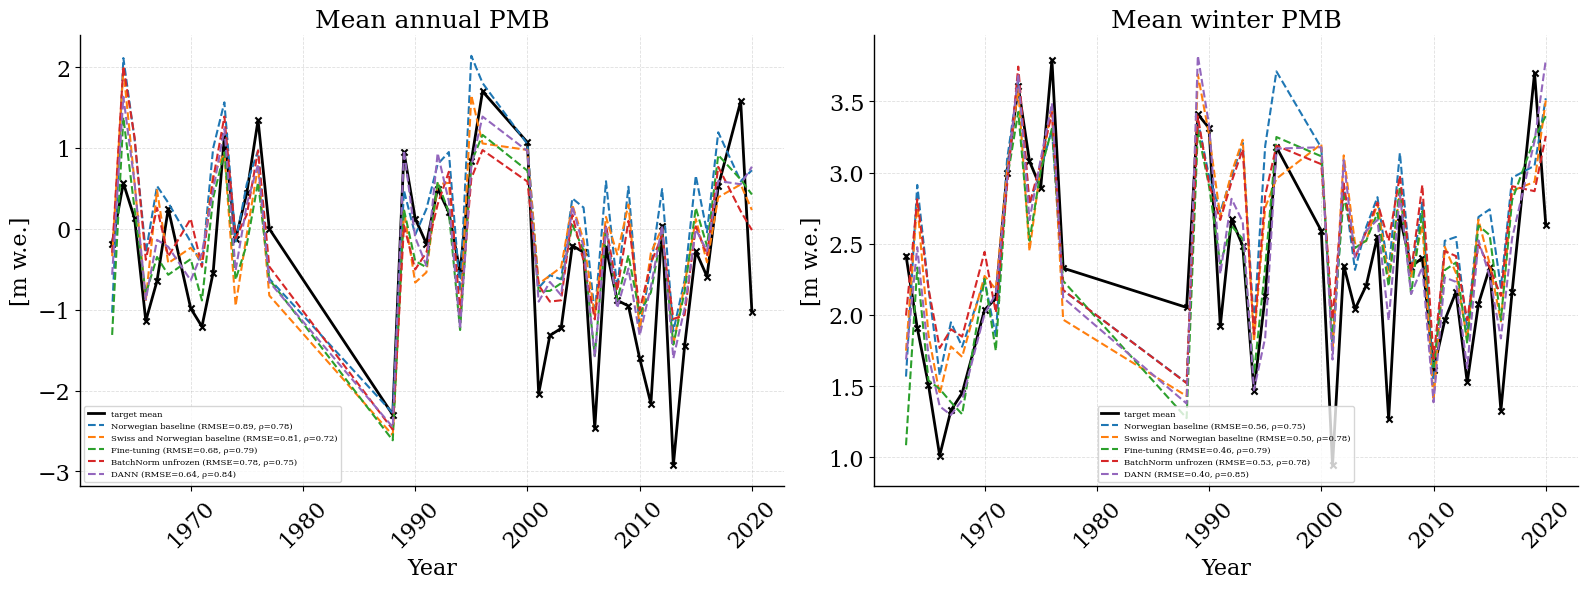

In [ ]:
def plot_mean_pmb_multi(models_grouped, title_prefix='Mean PMB'):
    """
    models_grouped: dict[str -> DataFrame] where each DF has columns
      ['target','ID','pred','PERIOD','GLACIER','YEAR'] as returned by loader above.
    """
    # Use the first model’s DF as reference for ground-truth shading (same targets for all)
    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()

    # Prepare figure
    fig, (ax_ann, ax_win) = plt.subplots(1, 2, figsize=(16, 6))
    ax_ann.set_title('Mean annual PMB', fontsize=18)
    ax_win.set_title('Mean winter PMB', fontsize=18)

    # Colors for models
    palette = sns.color_palette("tab10", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho

    # Helper to plot one panel (annual or winter)
    def _plot_panel(ax, period_name):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())

        # Ground-truth mean line (black)
        tgt_mean = df_period.groupby('YEAR')['target'].mean().reindex(years)
        ax.plot(years, tgt_mean, color="black", label="target mean", linewidth=2)
        ax.scatter(years, tgt_mean, color="black", marker='x', s=20)

        # Plot each model’s mean prediction per year and compute metrics (per period)
        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean().reindex(years)

            # Compute RMSE and Pearson r for this period (use per-ID means)
            metrics_df = pd.DataFrame({
                'YEAR': years,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            ).rename(columns={'target': 'target'})
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, \u03C1={np.nan_to_num(rho):.2f})"
            ax.plot(years, pred_mean, label=label_with_metrics,
                    color=label_to_color.get(label, None), linestyle='--')
            #ax.scatter(years, pred_mean, color=label_to_color.get(label, None), s=15)

        ax.set_xlabel('Year')
        ax.set_ylabel('[m w.e.]')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(fontsize=6, loc='best')

    _plot_panel(ax_ann, 'annual')
    _plot_panel(ax_win, 'winter')

    plt.tight_layout()
    plt.show()


base = grouped_ids[['ID', 'target', 'PERIOD', 'GLACIER', 'YEAR']].copy()

# List models (optionally mix NN and DANN). Provide up to 5.
"""
# 50% 4 glaciers
models = [
    #('CH baseline',  'nn_model_2025-07-14_CH_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Norwegian baseline',  'nn_model_2025-07-14_4_glaciers_regional_baseline_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Swiss and Norwegian baseline',  'nn_model_2025-08-12_CH_and_4_glaciers_regional_baseline_flexible_only_NOR_val.pt', mbm.models.CustomNeuralNetRegressor),
    ('Fine-tuning',  'nn_model_finetuned_2025-08-19_4_glaciers_fine_tuning_lr0.00005_epoch_20.pt', mbm.models.CustomNeuralNetRegressor),
    ('BatchNorm unfrozen',  'nn_model_finetuned_2025-08-19_4_glaciers_batchnorm_unfrozen_linear_frozen_lr0.1_epoch200.pt', mbm.models.CustomNeuralNetRegressor),
    ('DANN',      'dann_model_2025-08-19_2nd_try_4_glaciers_50%_lamba0_05_mean_domainloss_even_domainloss_only_NOR_val.pt', CustomDANNRegressor),
]
"""
"""
# 50% kMeans
models = [
    #('CH baseline',  'nn_model_2025-07-14_CH_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Norwegian baseline',  'nn_model_2025-09-07_50%_kmeans_regional_baseline.pt', mbm.models.CustomNeuralNetRegressor),
    ('Swiss and Norwegian baseline',  'nn_model_2025-09-07_50%_kmeans_CH_and_regional_baseline_only_NOR_val.pt', mbm.models.CustomNeuralNetRegressor),
    ('Fine-tuning',  'nn_model_finetuned_2025-09-07_50%_kMeans_fine_tuning_lr0.00005_epoch_10.pt', mbm.models.CustomNeuralNetRegressor),
    ('BatchNorm unfrozen',  'nn_model_finetuned_2025-09-07_50%_kMeans_batchnorm_unfrozen_linear_frozen_lr0.1_epoch200.pt', mbm.models.CustomNeuralNetRegressor),
    ('DANN',      'dann_model_2025-09-07_50%_kMeans_lambda0_05_mean_domainloss_even_domainloss_only_NOR_val_50_50_epochsplit_epoch60.pt', CustomDANNRegressor),
]
"""
"""
# 5-10%
models = [
    #('CH baseline',  'nn_model_2025-07-14_CH_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Norwegian baseline',  'nn_model_2025-07-15_7_glaciers_regional_baseline_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Swiss and Norwegian baseline',  'nn_model_2025-08-14_CH_and_7_glaciers_regional_baseline_flexible_only_NOR_val.pt', mbm.models.CustomNeuralNetRegressor),
    ('Fine-tuning',  'nn_model_finetuned_2025-08-21_5-10%_glaciers_fine_tuning_lr0.0001_epoch_100.pt', mbm.models.CustomNeuralNetRegressor),
    ('BatchNorm unfrozen',  'nn_model_finetuned_2025-08-21_5-10%_batchnorm_unfrozen_linear_frozen_lr0.05_epoch200.pt', mbm.models.CustomNeuralNetRegressor),
    ('DANN',      'dann_model_2025-09-12_5-10%_lambda0_05_mean_domainloss_even_domainloss_only_NOR_val_50_50_epochsplit.pt', CustomDANNRegressor),
]
"""


# 63lat
models = [
    #('CH baseline',  'nn_model_2025-07-14_CH_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Norwegian baseline',  'nn_model_2025-08-26_63lat_regional_baseline_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Swiss and Norwegian baseline',  'nn_model_2025-08-26_63lat_CH_and_regional_baseline_flexible_only_NOR_val.pt', mbm.models.CustomNeuralNetRegressor),
    ('Fine-tuning',  'nn_model_finetuned_2025-08-26_63lat_fine_tuning_lr0.005_epoch_30.pt', mbm.models.CustomNeuralNetRegressor),
    ('BatchNorm unfrozen',  'nn_model_finetuned_2025-08-26_63lat_batchnorm_unfrozen_linear_frozen_lr0.05_epoch200.pt', mbm.models.CustomNeuralNetRegressor),
    ('DANN',      'dann_model_2025-08-26_63lat_lambda0_05_mean_domainloss_even_domainloss_only_NOR_val_50_50_epochsplit.pt', CustomDANNRegressor),
]


device = 'cpu'

nn_loader_args = {**swiss_args, **param_init}
try:
    _ = DANNNetwork
    dann_loader_args = {
        **{
            **args_dann,
            'module': DANNNetwork,
            'module__domain_hidden': params_dann.get('module__domain_hidden', 64),
            'module__grl_lambda': params_dann.get('module__grl_lambda', 1.0),
        },
        'dan_lambda': 0.05,  # inference-only, safe if different from train
        **param_init,
    }
except NameError:
    dann_loader_args = None

models_grouped = {}

for label, fname, model_cls in models:
    print(f'Loading {label}: {fname}')

    if model_cls.__name__ == 'CustomDANNRegressor':
        if dann_loader_args is None:
            raise NameError("DANNNetwork not available. Run the DANN components cell before loading DANN models.")
        mdl = model_cls.load_model(cfg, fname, **dann_loader_args)
    else:
        mdl = model_cls.load_model(cfg, fname, **nn_loader_args)

    mdl = mdl.set_params(device=device).to(device)

    # Predict aggregated by measurement ID using the same dataset_test
    y_pred_agg = mdl.aggrPredict(dataset_test[0])

    assert len(y_pred_agg) == len(base), f'Length mismatch for {label}'
    gdf = base.copy()
    gdf['pred'] = y_pred_agg
    models_grouped[label] = gdf

# Plot mean annual and mean winter PMB for all models together
plot_mean_pmb_multi(models_grouped)

### This is the one

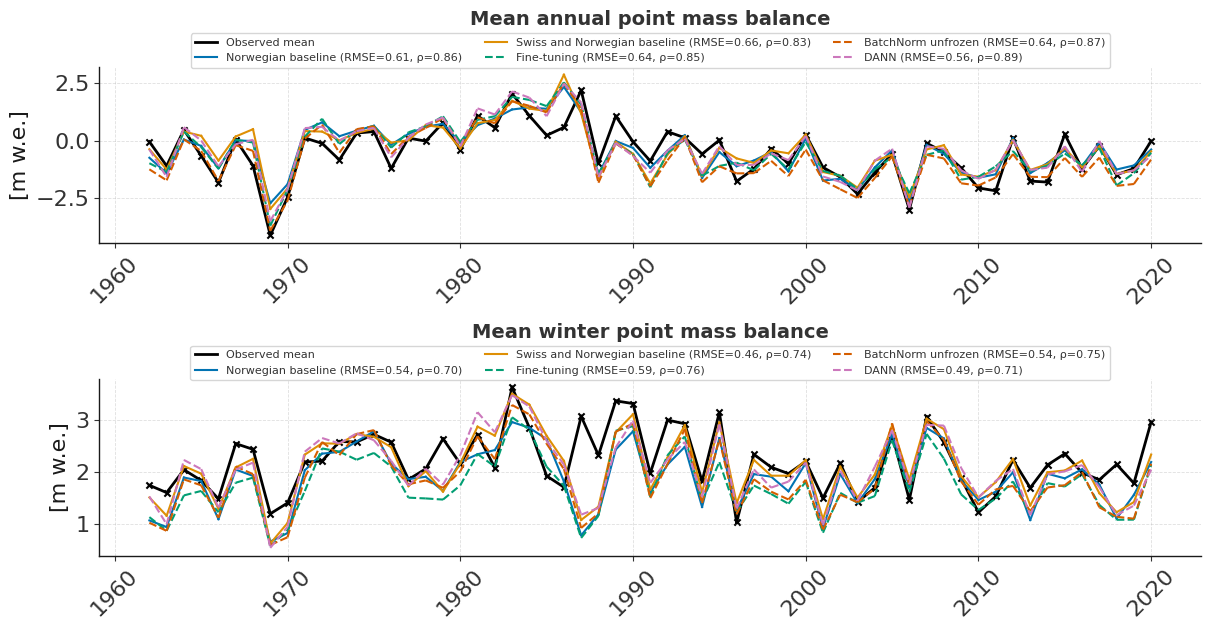

In [ ]:
def plot_mean_pmb_multi_fixed_lines(models_grouped, title_prefix='Mean PMB'):

    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()


    fig, (ax_ann, ax_win) = plt.subplots(2, 1, figsize=(12, 8))


    ax_ann.set_title('Mean annual point mass balance', fontsize=14, fontweight='bold', pad=30)
    ax_win.set_title('Mean winter point mass balance', fontsize=14, fontweight='bold', pad=30)


    palette = sns.color_palette("colorblind", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}


    regional_models = ['Norwegian Baseline', 'Swiss and Norwegian Baseline']
    transfer_models = ['Fine-tuning', 'BatchNorm unfrozen', 'DANN']
    line_styles = {model: '-' for model in regional_models}
    line_styles.update({model: '--' for model in transfer_models})

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho


    def _plot_panel(ax, period_name):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())


        tgt_mean = df_period.groupby('YEAR')['target'].mean()
        available_years = tgt_mean.index.values
        available_values = tgt_mean.values
        

        target_line_plotted = False
        for i in range(len(available_years) - 1):
            if available_years[i+1] - available_years[i] == 1:
                if not target_line_plotted:

                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6,
                           label="Observed mean")
                    target_line_plotted = True
                else:

                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2)
        

        ax.scatter(available_years, available_values, color="black", marker='x', s=20)
        

        if not target_line_plotted:
            ax.scatter(available_years, available_values, color="black", marker='x', s=20, 
                      label="Observed mean")


        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean()


            metrics_df = pd.DataFrame({
                'YEAR': pred_mean.index,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            )
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, \u03C1={np.nan_to_num(rho):.2f})"
            

            pred_years = pred_mean.index.values
            pred_values = pred_mean.values
            
            for i in range(len(pred_years) - 1):
                if pred_years[i+1] - pred_years[i] == 1: 
                    ax.plot([pred_years[i], pred_years[i+1]], 
                           [pred_values[i], pred_values[i+1]], 
                           color=label_to_color.get(label, None), 
                           linestyle=line_styles.get(label, '-'),
                           label=label_with_metrics if i == 0 else "")

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)

    _plot_panel(ax_ann, 'annual')
    _plot_panel(ax_win, 'winter')


    ax_ann.legend(fontsize=8, loc='upper center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.22))
    ax_win.legend(fontsize=8, loc='upper center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.22))


    ax_ann.set_ylabel('[m w.e.]')
    ax_win.set_ylabel('[m w.e.]')


    plt.tight_layout(rect=(0, 0, 1, 0.8))
    plt.show()


plot_mean_pmb_multi_fixed_lines(models_grouped)

### plots for power point

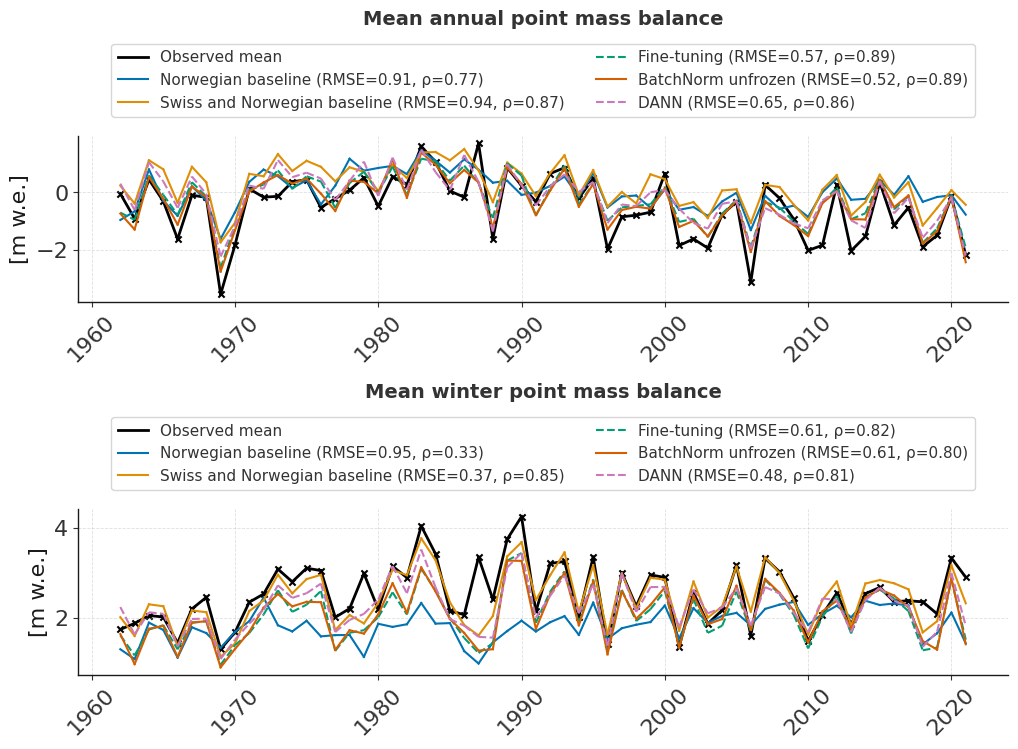

In [ ]:
def plot_mean_pmb_multi_fixed_lines(models_grouped, title_prefix='Mean PMB'):

    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()

    fig, (ax_ann, ax_win) = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'hspace': 1.25})


    ax_ann.set_title('Mean annual point mass balance', fontsize=14, fontweight='bold', pad=80)
    ax_win.set_title('Mean winter point mass balance', fontsize=14, fontweight='bold', pad=80)


    palette = sns.color_palette("colorblind", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}


    regional_models = ['Regional baseline', 'CH and regional baseline']
    transfer_models = ['Fine-tuning', 'Batchnorm unfrozen', 'DANN']
    line_styles = {model: '-' for model in regional_models}
    line_styles.update({model: '--' for model in transfer_models})

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho


    def _plot_panel(ax, period_name):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())


        tgt_mean = df_period.groupby('YEAR')['target'].mean()
        available_years = tgt_mean.index.values
        available_values = tgt_mean.values
        

        target_line_plotted = False
        for i in range(len(available_years) - 1):
            if available_years[i+1] - available_years[i] == 1: 
                if not target_line_plotted:

                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6,
                           label="Observed mean")
                    target_line_plotted = True
                else:

                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2)
        

        ax.scatter(available_years, available_values, color="black", marker='x', s=20)
        

        if not target_line_plotted:
            ax.scatter(available_years, available_values, color="black", marker='x', s=20, 
                      label="Observed mean")


        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean()


            metrics_df = pd.DataFrame({
                'YEAR': pred_mean.index,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            )
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, \u03C1={np.nan_to_num(rho):.2f})"
            

            pred_years = pred_mean.index.values
            pred_values = pred_mean.values
            
            for i in range(len(pred_years) - 1):
                if pred_years[i+1] - pred_years[i] == 1: 
                    ax.plot([pred_years[i], pred_years[i+1]], 
                           [pred_values[i], pred_values[i+1]], 
                           color=label_to_color.get(label, None), 
                           linestyle=line_styles.get(label, '-'),
                           label=label_with_metrics if i == 0 else "")

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)

    _plot_panel(ax_ann, 'annual')
    _plot_panel(ax_win, 'winter')


    ax_ann.legend(fontsize=11, loc='upper center', ncol=2, frameon=True, bbox_to_anchor=(0.5, 1.6))
    ax_win.legend(fontsize=11, loc='upper center', ncol=2, frameon=True, bbox_to_anchor=(0.5, 1.6))


    ax_ann.set_ylabel('[m w.e.]')
    ax_win.set_ylabel('[m w.e.]')


    #plt.tight_layout(rect=(0, 0, 1, 0.8))  # Much more space at top
    plt.show()

plot_mean_pmb_multi_fixed_lines(models_grouped)

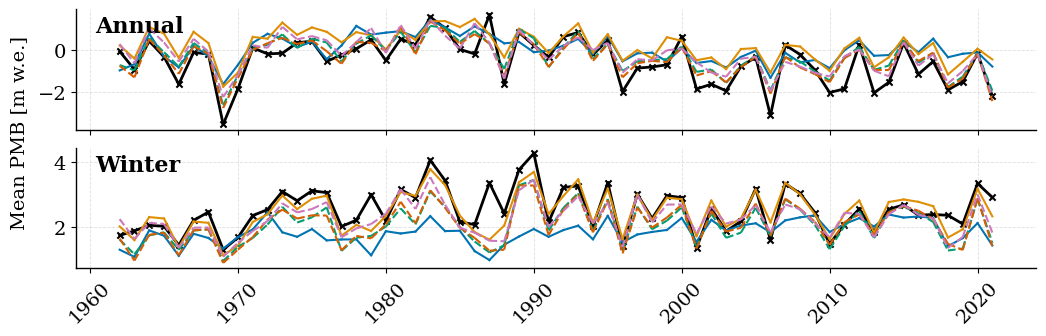

In [17]:
from matplotlib.ticker import MaxNLocator
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams.update({
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'axes.edgecolor': 'black',
        'figure.edgecolor': 'black'
    })

def plot_mean_pmb_multi_fixed_lines(models_grouped, title_prefix='Mean PMB'):

    # Use the first model's DF as reference for ground-truth shading (same targets for all)
    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()

    # Prepare figure with shared x-axis
    fig, (ax_ann, ax_win) = plt.subplots(2, 1, figsize=(12, 3.5), 
                                         gridspec_kw={'hspace': 0.15}, 
                                         sharex=True)

    # Colors for models
    palette = sns.color_palette("colorblind", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}

    # Define line styles for regional and transfer learning models
    regional_models = ['Norwegian baseline', 'Swiss and Norwegian baseline']
    transfer_models = ['Fine-tuning', 'BatchNorm unfrozen', 'DANN']
    line_styles = {model: '-' for model in regional_models}
    line_styles.update({model: '--' for model in transfer_models})

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho

    # Helper to plot one panel (annual or winter)
    def _plot_panel(ax, period_name, show_legend=False):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())

        # Ground-truth mean line (black)
        tgt_mean = df_period.groupby('YEAR')['target'].mean()
        available_years = tgt_mean.index.values
        available_values = tgt_mean.values
        
        target_line_plotted = False
        for i in range(len(available_years) - 1):
            if available_years[i+1] - available_years[i] == 1:
                if not target_line_plotted:
                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6,
                           label="Observed mean")
                    target_line_plotted = True
                else:
                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2)
        
        ax.scatter(available_years, available_values, color="black", marker='x', s=20)
        
        if not target_line_plotted:
            ax.scatter(available_years, available_values, color="black", marker='x', s=20, 
                      label="Observed mean")

        # Plot model predictions
        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean()

            metrics_df = pd.DataFrame({
                'YEAR': pred_mean.index,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            )
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, ρ={np.nan_to_num(rho):.2f})"
            
            pred_years = pred_mean.index.values
            pred_values = pred_mean.values
            
            label_added = False
            for i in range(len(pred_years) - 1):
                if pred_years[i+1] - pred_years[i] == 1:
                    ax.plot([pred_years[i], pred_years[i+1]], 
                           [pred_values[i], pred_values[i+1]], 
                           color=label_to_color.get(label, None), 
                           linestyle=line_styles.get(label, '-'),
                           label=label if not label_added and show_legend else "")
                    label_added = True
            
            if not label_added and len(pred_years) > 0 and show_legend:
                ax.plot([], [], 
                       color=label_to_color.get(label, None), 
                       linestyle=line_styles.get(label, '-'),
                       label=label_with_metrics)

        ax.grid(True, linestyle='--', alpha=0.4)
        
        # Increase tick label font size
        ax.tick_params(axis='both', labelsize=14)

        ax.yaxis.set_major_locator(MaxNLocator(integer=True,nbins=3))

    # Plot annual data (upper panel)
    _plot_panel(ax_ann, 'annual', show_legend=True)
    ax_ann.text(0.02, 0.95, 'Annual', transform=ax_ann.transAxes, fontsize=16, 
                fontweight='bold', verticalalignment='top')
    
    # Single legend at top
    #ax_ann.legend(fontsize=13.9, loc='upper center', ncol=3, frameon=True, 
                  #bbox_to_anchor=(0.5, 1.65))

    # Plot winter data (lower panel)
    _plot_panel(ax_win, 'winter', show_legend=False)
    ax_win.text(0.02, 0.95, 'Winter', transform=ax_win.transAxes, fontsize=16, 
                fontweight='bold', verticalalignment='top')
    ax_win.tick_params(axis='x', rotation=45, labelsize=14)
    
    # Add shared y-axis label
    fig.text(0.045, 0.5, 'Mean PMB [m w.e.]', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, left=0.1)  # Make room for legend and y-label
    plt.show()

# Plot mean annual and mean winter PMB for all models together
plot_mean_pmb_multi_fixed_lines(models_grouped)

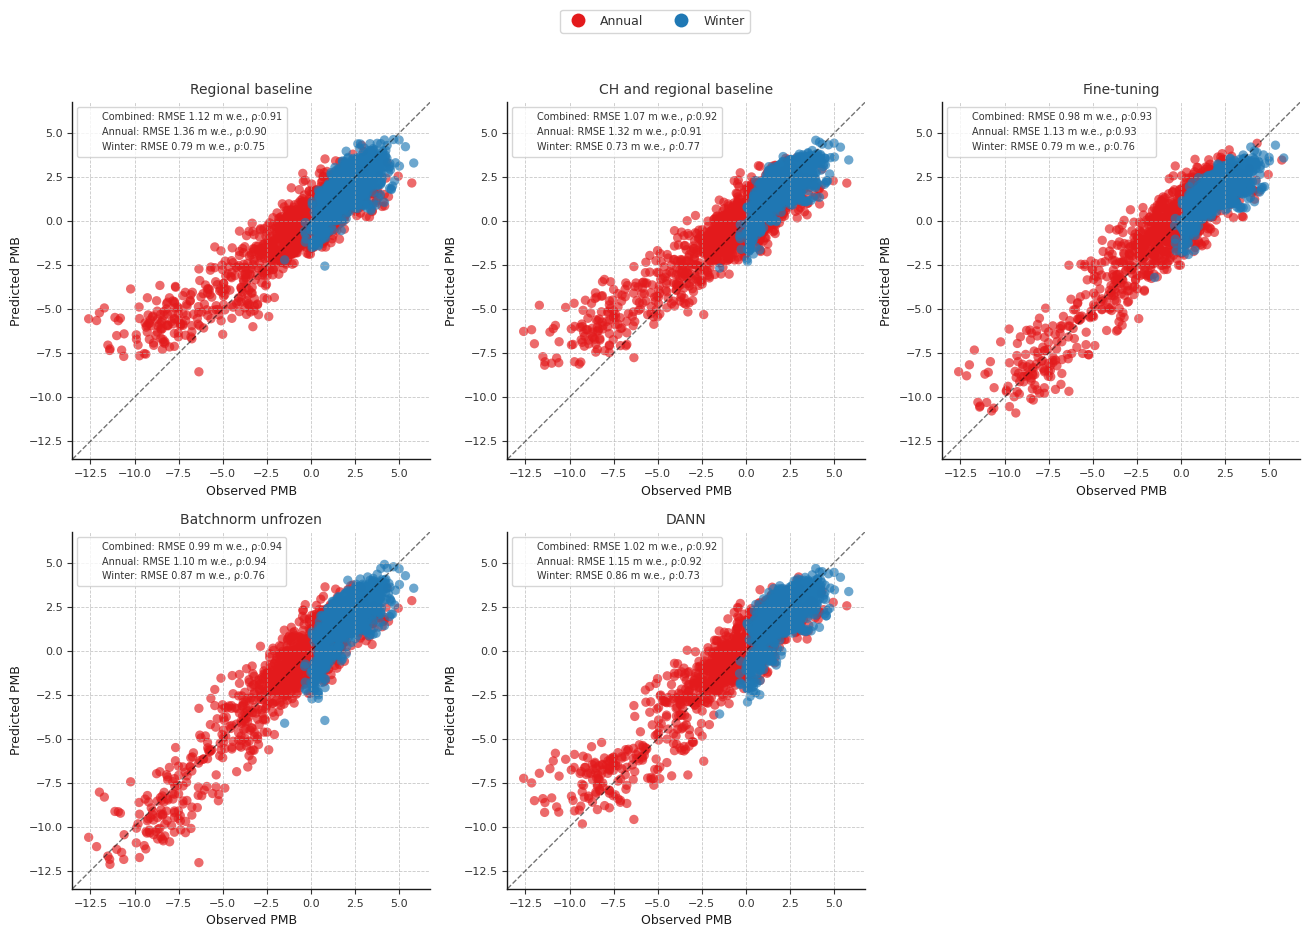

In [ ]:
def plot_pred_vs_obs_grid(models_grouped, ncols=3, point_size=45, region_name='CH->NOR'):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    period_colors = {'annual': '#e31a1c', 'winter': '#1f78b4'}
    labels = list(models_grouped.keys())
    n_models = len(labels)
    ncols_eff = min(ncols, n_models)
    nrows = int(np.ceil(n_models / ncols_eff))

    # Global axis limits
    all_targets = np.concatenate([models_grouped[l].target.values for l in labels])
    all_preds   = np.concatenate([models_grouped[l].pred.values   for l in labels])
    gmin = np.nanmin([all_targets.min(), all_preds.min()])
    gmax = np.nanmax([all_targets.max(), all_preds.max()])
    pad = 0.05 * (gmax - gmin)
    gmin -= pad
    gmax += pad

    fig, axes = plt.subplots(nrows, ncols_eff,
                             figsize=(4.4 * ncols_eff, 4.6 * nrows),
                             squeeze=False)
    metrics_all = {}

    for i, label in enumerate(labels):
        r, c = divmod(i, ncols_eff)
        ax = axes[r][c]
        df_plot = models_grouped[label]
        df_plot = df_plot[df_plot.PERIOD.isin(['annual','winter'])].copy()

        # Metrics per period
        panel_metrics = {}
        for period in ['annual','winter']:
            sub = df_plot[df_plot.PERIOD == period]
            if len(sub):
                y_t = sub.target.values
                y_p = sub.pred.values
                rmse = np.sqrt(np.mean((y_p - y_t)**2))
                rho  = np.corrcoef(y_t, y_p)[0,1] if len(sub) > 1 else np.nan
                panel_metrics[period] = (rmse, rho)

        # Combined
        y_t_all = df_plot.target.values
        y_p_all = df_plot.pred.values
        rmse_all = np.sqrt(np.mean((y_p_all - y_t_all)**2))
        rho_all  = np.corrcoef(y_t_all, y_p_all)[0,1] if len(df_plot) > 1 else np.nan
        panel_metrics['combined'] = (rmse_all, rho_all)
        metrics_all[label] = panel_metrics

        # Scatter (no per‑subplot point handles; handled globally)
        for period in ['annual','winter']:
            sub = df_plot[df_plot.PERIOD == period]
            if len(sub):
                ax.scatter(sub.target, sub.pred,
                           s=point_size, alpha=0.65, edgecolor='none',
                           color=period_colors[period])

        # 1:1 line + handle for subplot legend
        ax.plot([gmin,gmax],[gmin,gmax],'k--',linewidth=1,alpha=0.55)

        # Metric legend entries
        def metric_handle(name, key):
            rmse, rho = panel_metrics[key]
            return Line2D([],[], linestyle='',
                          label=f"{name}: RMSE {rmse:.2f} m w.e., ρ:{rho:.2f}",
                          color='none')

        metric_handles = [
            metric_handle("Combined", 'combined'),
            *( [metric_handle("Annual", 'annual')] if 'annual' in panel_metrics else [] ),
            *( [metric_handle("Winter", 'winter')] if 'winter' in panel_metrics else [] ),
        ]

        ax.set_xlim(gmin,gmax)
        ax.set_ylim(gmin,gmax)
        ax.set_title(label, fontsize=10)
        ax.tick_params(labelsize=8)
        ax.set_xlabel('Observed PMB', fontsize=9)
        ax.set_ylabel('Predicted PMB', fontsize=9)

        # Subplot legend: only 1:1 + metrics
        ax.legend(handles=metric_handles,
                  fontsize=7, loc='upper left',
                  frameon=True, handlelength=1.2, borderpad=0.5)

    # Hide unused axes
    for j in range(n_models, nrows * ncols_eff):
        r, c = divmod(j, ncols_eff)
        axes[r][c].axis('off')

    # Global legend for point types (annual / winter)
    global_point_handles = [
        Line2D([0],[0], marker='o', linestyle='', color=period_colors['annual'],
               label='Annual'),
        Line2D([0],[0], marker='o', linestyle='', color=period_colors['winter'],
               label='Winter')
    ]
    fig.legend(handles=global_point_handles,
               loc='upper center',
               ncol=2,
               frameon=True,
               fontsize=9,
               bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=(0,0,1,0.95))
    return metrics_all

pred_grid_metrics = plot_pred_vs_obs_grid(models_grouped, ncols=3, region_name='CH->NOR')

In [ ]:
def create_model_comparison_table(models_grouped, periods=['annual', 'winter', 'combined']):
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Define the desired order of models
    desired_order = [
        'Norwegian baseline',
        'Swiss and Norwegian baseline', 
        'Fine-tuning',
        'BatchNorm unfrozen',
        'DANN'
    ]
    
    results = []
    
    for model_name in desired_order:
        if model_name not in models_grouped:
            continue
            
        df = models_grouped[model_name]

        df_filtered = df[df['PERIOD'].isin(['annual', 'winter'])].copy()
        

        for period in periods:
            if period == 'combined':
 
                period_data = df_filtered
                period_label = 'Combined'
            else:

                period_data = df_filtered[df_filtered['PERIOD'] == period]
                period_label = period.capitalize()
            
            if len(period_data) == 0:
                continue
                
            y_true = period_data['target'].values
            y_pred = period_data['pred'].values
            

            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            r2 = r2_score(y_true, y_pred)
            rho = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
            bias = np.mean(y_pred - y_true) 
            
            results.append({
                'Model': model_name,
                'Period': period_label,
                'N_samples': len(period_data),
                'MAE': mae,
                'RMSE': rmse,
                'Bias': bias,
                'ρ': rho,
                'R²': r2,
                
            })
    

    results_df = pd.DataFrame(results)
    

    metrics = ['N_samples', 'MAE', 'RMSE', 'Bias', 'ρ', 'R²']


    pivot_tables = []
    for metric in metrics:
        pivot = results_df.pivot(index='Model', columns='Period', values=metric)
        pivot.name = metric
        pivot_tables.append(pivot)
    

    combined_table = pd.concat(pivot_tables, axis=1, keys=metrics)
    

    combined_table = combined_table.reindex(desired_order)
    

    if 'Combined' in combined_table.columns.get_level_values(1):
        period_order = ['Combined', 'Annual', 'Winter']
    else:
        period_order = ['Annual', 'Winter']
    

    new_columns = []
    for metric in metrics:
        for period in period_order:
            if (metric, period) in combined_table.columns:
                new_columns.append((metric, period))
    
    combined_table = combined_table[new_columns]
    

    numeric_metrics = ['MAE', 'RMSE', 'Bias', 'ρ', 'R²']
    for metric in numeric_metrics:
        for period in period_order:
            if (metric, period) in combined_table.columns:
                combined_table[(metric, period)] = combined_table[(metric, period)].round(2)
    
    return combined_table

def display_model_comparison_table(models_grouped):
    """
    Display a nicely formatted comparison table for all models.
    """
    table = create_model_comparison_table(models_grouped)
    
    print("="*80)
    print("MODEL PERFORMANCE COMPARISON TABLE")
    print("="*80)
    print()

    print(table.to_string())
    
    print()
    print("Metrics explanation:")
    print("- N_samples: Number of data points")
    print("- MAE: Mean Absolute Error [m w.e.]")
    print("- RMSE: Root Mean Square Error [m w.e.]") 
    print("- Bias: Mean bias (predicted - observed) [m w.e.]")
    print("- R²: Coefficient of determination")
    print("- ρ: Pearson correlation coefficient")
    print("="*80)
    
    return table


comparison_table = display_model_comparison_table(models_grouped)

# Optionally, save to CSV
#comparison_table.to_csv('50%_model_comparison_nor.csv')

MODEL PERFORMANCE COMPARISON TABLE

                             N_samples                    MAE                   RMSE                   Bias                      ρ                     R²              
Period                        Combined Annual Winter Combined Annual Winter Combined Annual Winter Combined Annual Winter Combined Annual Winter Combined Annual Winter
Model                                                                                                                                                                  
Norwegian baseline                1360    699    661     0.85   1.03   0.67     1.13   1.35   0.84     0.56   0.69   0.41     0.87   0.81   0.73     0.68   0.53   0.39
Swiss and Norwegian baseline      1360    699    661     0.83   1.00   0.64     1.13   1.35   0.83     0.36   0.40   0.33     0.85   0.75   0.72     0.68   0.52   0.42
Fine-tuning                       1360    699    661     0.74   0.91   0.57     0.98   1.18   0.73     0.16   0.17   0.15   

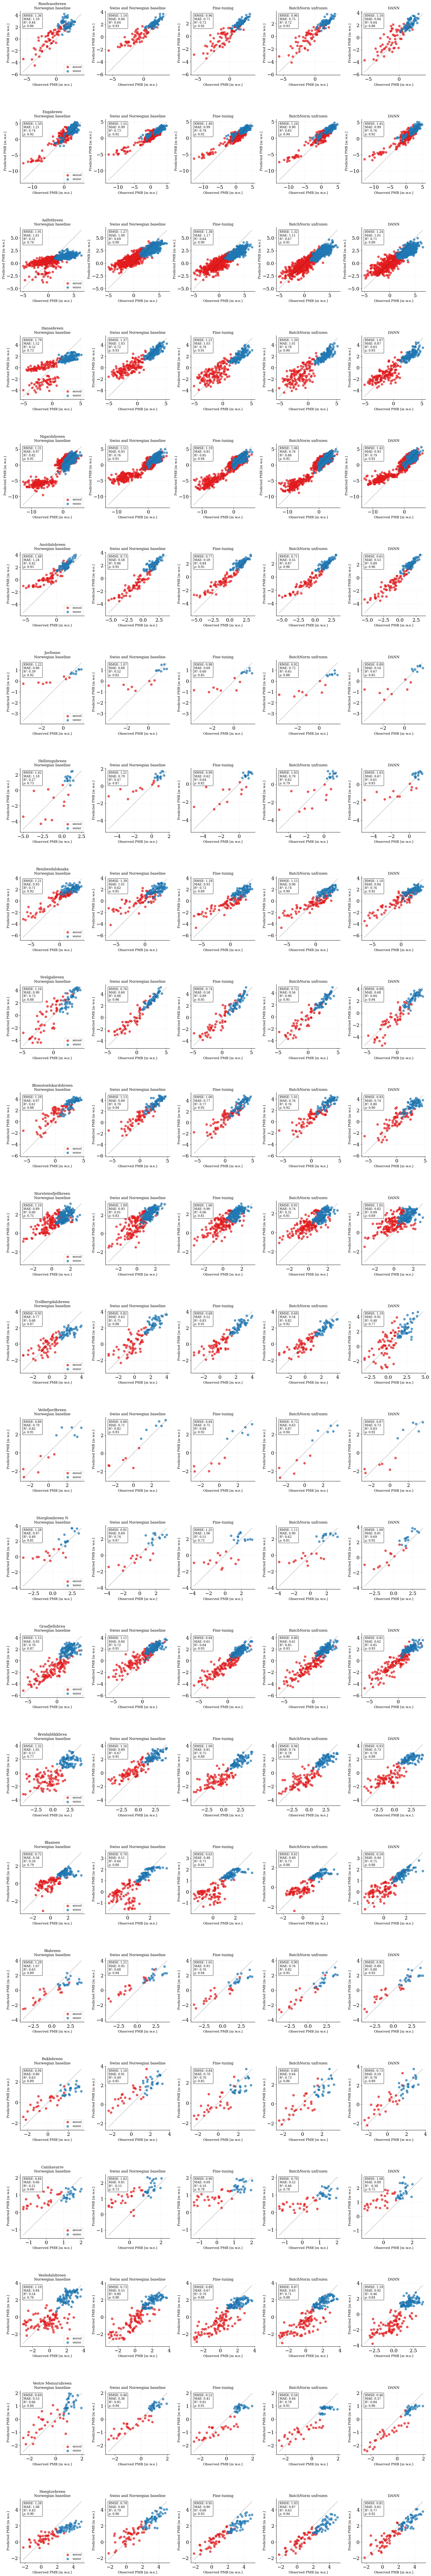

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def PlotIndividualGlacierPredVsTruth_Multi(models_grouped, base_figsize=(20, 15), height_per_row=5, ncols_models=2):
    
    # Get unique glaciers from the first model (should be same for all)
    first_model = next(iter(models_grouped.values()))
    unique_glaciers = first_model['GLACIER'].unique()
    n_glaciers = len(unique_glaciers)
    
    # Color palette for periods
    color_palette_period = {
        'annual': '#e31a1c',
        'winter': '#1f78b4'
    }
    
    # Calculate subplot layout
    n_models = len(models_grouped)
    ncols_total = min(ncols_models, n_models)
    nrows_models = int(np.ceil(n_models / ncols_total))
    
    # Create figure with subplots for each glacier
    fig = plt.figure(figsize=(base_figsize[0], n_glaciers * height_per_row))
    
    for glacier_idx, glacier_name in enumerate(unique_glaciers):
        # Create a grid for this glacier's models
        for model_idx, (model_name, model_df) in enumerate(models_grouped.items()):
            
            # Calculate subplot position
            subplot_idx = glacier_idx * n_models + model_idx + 1
            ax = plt.subplot(n_glaciers, n_models, subplot_idx)
            
            # Filter data for this glacier
            df_gl = model_df[model_df['GLACIER'] == glacier_name].copy()
            
            if len(df_gl) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{glacier_name}\n{model_name}', fontsize=12)
                continue
            
            # Calculate metrics including R²
            y_true = df_gl['target'].values
            y_pred = df_gl['pred'].values
            
            scores = {
                'mse': mean_squared_error(y_true, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                'mae': mean_absolute_error(y_true, y_pred),
                'r2': r2_score(y_true, y_pred),
                'pearson_corr': np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
            }
            
            # Create scatter plot colored by period
            for period in df_gl['PERIOD'].unique():
                if period in color_palette_period:
                    period_data = df_gl[df_gl['PERIOD'] == period]
                    ax.scatter(period_data['target'], period_data['pred'], 
                             c=color_palette_period[period], 
                             label=period, alpha=0.7, s=50)
            
            # Add 1:1 line
            min_val = min(df_gl['target'].min(), df_gl['pred'].min())
            max_val = max(df_gl['target'].max(), df_gl['pred'].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)

            ax.set_aspect('equal', adjustable='box')
            
            # Add metrics text
            metrics_text = (f"RMSE: {scores['rmse']:.2f}\n"
                          f"MAE: {scores['mae']:.2f}\n" 
                          f"R²: {scores['r2']:.2f}\n"
                          f"ρ: {scores['pearson_corr']:.2f}")
            
            ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
                   verticalalignment='top', fontsize=10,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Set labels and title
            ax.set_xlabel('Observed PMB [m w.e.]', fontsize=11)
            ax.set_ylabel('Predicted PMB [m w.e.]', fontsize=11)
            
            # Title shows glacier name for first model in row, model name for all
            if model_idx == 0:
                title = f'{glacier_name}\n{model_name}'
            else:
                title = model_name
            ax.set_title(title, fontsize=12)
            
            # Add legend only for first subplot of each glacier
            if model_idx == 0:
                ax.legend(fontsize=9, loc='lower right')
            
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

PlotIndividualGlacierPredVsTruth_Multi(models_grouped, base_figsize=(20, 15))

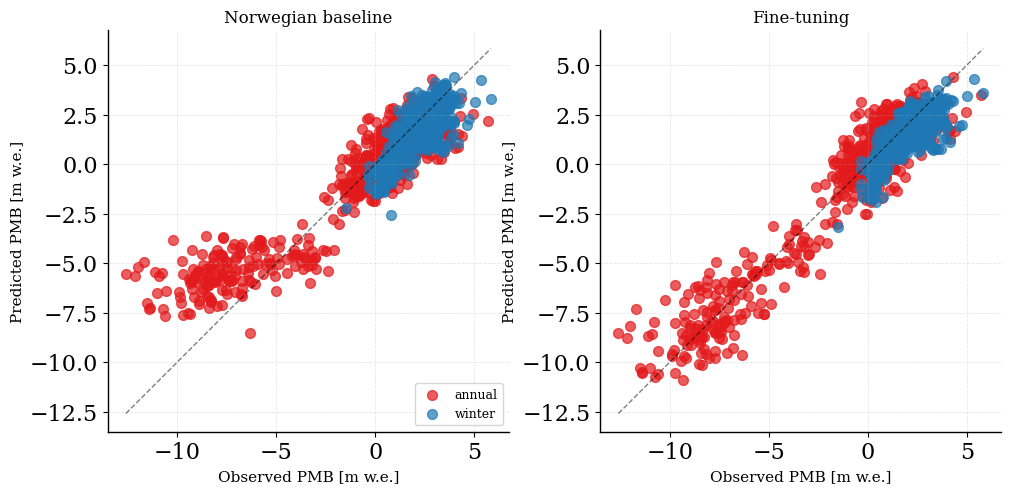

In [20]:
def PlotNigardsbreenOnly(models_grouped, models_to_plot=['Norwegian baseline', 'Fine-tuning']):
    
    # Color palette for periods
    color_palette_period = {
        'annual': '#e31a1c',
        'winter': '#1f78b4'
    }
    
    # Filter models to only those requested
    filtered_models = {k: v for k, v in models_grouped.items() if k in models_to_plot}
    n_models = len(filtered_models)
    
    # Create figure
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
    
    # Handle case where there's only one model
    if n_models == 1:
        axes = [axes]
    
    for model_idx, (model_name, model_df) in enumerate(filtered_models.items()):
        ax = axes[model_idx]
        
        # Filter data for Nigardsbreen only
        df_gl = model_df[model_df['GLACIER'] == 'Nigardsbreen'].copy()
        
        if len(df_gl) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Nigardsbreen\n{model_name}', fontsize=12)
            continue
        
        # Calculate metrics
        y_true = df_gl['target'].values
        y_pred = df_gl['pred'].values
        
        scores = {
            'rmse': np.sqrt(np.mean((y_pred - y_true)**2)),
            'mae': np.mean(np.abs(y_pred - y_true)),
            'r2': 1 - np.sum((y_pred - y_true)**2) / np.sum((y_true - y_true.mean())**2),
            'pearson_corr': np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
        }
        
        # Create scatter plot colored by period
        for period in df_gl['PERIOD'].unique():
            if period in color_palette_period:
                period_data = df_gl[df_gl['PERIOD'] == period]
                ax.scatter(period_data['target'], period_data['pred'], 
                         c=color_palette_period[period], 
                         label=period, alpha=0.7, s=50)
        
        # Add 1:1 line
        min_val = min(df_gl['target'].min(), df_gl['pred'].min())
        max_val = max(df_gl['target'].max(), df_gl['pred'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)

        ax.set_aspect('equal', adjustable='box')
        
        # Add metrics text
        metrics_text = (f"RMSE: {scores['rmse']:.2f}\n"
                      f"MAE: {scores['mae']:.2f}\n" 
                      f"R²: {scores['r2']:.2f}\n"
                      f"ρ: {scores['pearson_corr']:.2f}")
        
        #ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
               #verticalalignment='top', fontsize=10,
               #bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # Set labels and title
        ax.set_xlabel('Observed PMB [m w.e.]', fontsize=11)
        ax.set_ylabel('Predicted PMB [m w.e.]', fontsize=11)
        ax.set_title(model_name, fontsize=12)
        
        # Add legend for first subplot
        if model_idx == 0:
            ax.legend(fontsize=9, loc='lower right')
        
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot only Nigardsbreen with selected models
PlotNigardsbreenOnly(models_grouped)

In [52]:
def PlotPredictionsCombined_Nigardsbreen(grouped_ids, region_name="", include_summer=False, nticks=6, min_val=0.00, max_val=0.00):
    fig = plt.figure(figsize=(9.7, 9.7))
    period_colors = {'annual': '#e31a1c', 'winter': '#1f78b4', 'summer': '#33a02c'}

    # Compute metrics for each period
    metrics = {}
    for period in ['annual', 'winter', 'summer']:
        if period == 'summer' and not include_summer:
            continue
        subset = grouped_ids[grouped_ids.PERIOD == period]
        if len(subset) > 0:
            rmse = np.sqrt(mean_squared_error(subset.target, subset.pred))
            r2 = r2_score(subset.target, subset.pred)
            # Pearson correlation
            if len(subset) > 1:
                rho = np.corrcoef(subset.target, subset.pred)[0, 1]
            else:
                rho = np.nan
            metrics[period] = (rmse, rho, r2)

    # Combined metrics
    rmse_all = np.sqrt(mean_squared_error(grouped_ids.target, grouped_ids.pred))
    r2_all = r2_score(grouped_ids.target, grouped_ids.pred)
    if len(grouped_ids) > 1:
        rho_all = np.corrcoef(grouped_ids.target, grouped_ids.pred)[0, 1]
    else:
        rho_all = np.nan
    metrics['combined'] = (rmse_all, rho_all, r2_all)

    ax = plt.subplot(1, 1, 1)
    for period in grouped_ids.PERIOD.unique():
        if period == 'summer' and not include_summer:
            continue
        subset = grouped_ids[grouped_ids.PERIOD == period]
        if len(subset) > 0:
            ax.scatter(subset.target, subset.pred,
                       color=period_colors.get(period, 'gray'),
                       alpha=0.7, s=80, label=f"{period}")

    # Calculate common axis limits and ticks
    if min_val == 0.00:
        min_val = min(grouped_ids.target.min(), grouped_ids.pred.min())
    if max_val == 0.00:
        max_val = max(grouped_ids.target.max(), grouped_ids.pred.max())
    
    # Add some padding
    range_val = max_val - min_val
    padding = range_val * 0.05
    min_val -= padding
    max_val += padding
    
    # Set equal limits for both axes
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    # Force equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    ax.xaxis.set_major_locator(MaxNLocator(nbins=nticks))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=nticks))
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=2)

    # Build metrics text for top left (RMSE values)
    rmse_text = f"RMSE$_{{\\mathbf{{C}}}}$: {metrics['combined'][0]:.2f}\n"
    if 'annual' in metrics:
        rmse_text += f"RMSE$_{{\\mathbf{{A}}}}$: {metrics['annual'][0]:.2f}\n"
    if 'winter' in metrics:
        rmse_text += f"RMSE$_{{\\mathbf{{W}}}}$: {metrics['winter'][0]:.2f}"
    if include_summer and 'summer' in metrics:
        rmse_text += f"\nRMSE$_{{\\mathbf{{S}}}}$: {metrics['summer'][0]:.2f}"
    
    # Build metrics text for bottom right (rho and R² values)
    corr_text = f"ρ$_{{\\mathbf{{C}}}}$: {metrics['combined'][1]:.2f}, R²$_{{\\mathbf{{C}}}}$: {metrics['combined'][2]:.2f}\n"
    if 'annual' in metrics:
        corr_text += f"ρ$_{{\\mathbf{{A}}}}$: {metrics['annual'][1]:.2f}, R²$_{{\\mathbf{{A}}}}$: {metrics['annual'][2]:.2f}\n"
    if 'winter' in metrics:
        corr_text += f"ρ$_{{\\mathbf{{W}}}}$: {metrics['winter'][1]:.2f}, R²$_{{\\mathbf{{W}}}}$: {metrics['winter'][2]:.2f}"
    if include_summer and 'summer' in metrics:
        corr_text += f"\nρ$_{{\\mathbf{{S}}}}$: {metrics['summer'][1]:.2f}, R²$_{{\\mathbf{{S}}}}$: {metrics['summer'][2]:.2f}"
        
    
    
    
    
    #ax.legend(fontsize=40, loc='upper left', ncol=1, 
              #borderpad=0.2, labelspacing=0.2, handletextpad=0.1, columnspacing=1.0)

    # ax.legend(fontsize=32, loc='upper left', borderpad=0.2,labelspacing=0.2,handletextpad=0.1)
    ax.set_xlabel('Observed PMB [m w.e.]', fontsize=40)
    ax.set_ylabel('Predicted PMB [m w.e.]', fontsize=40)
    ax.set_title(f'Fine-tuning', fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()


Loading and plotting: Norwegian baseline, Nigardsbreen
Model file: nn_model_2025-09-07_50%_kmeans_regional_baseline.pt


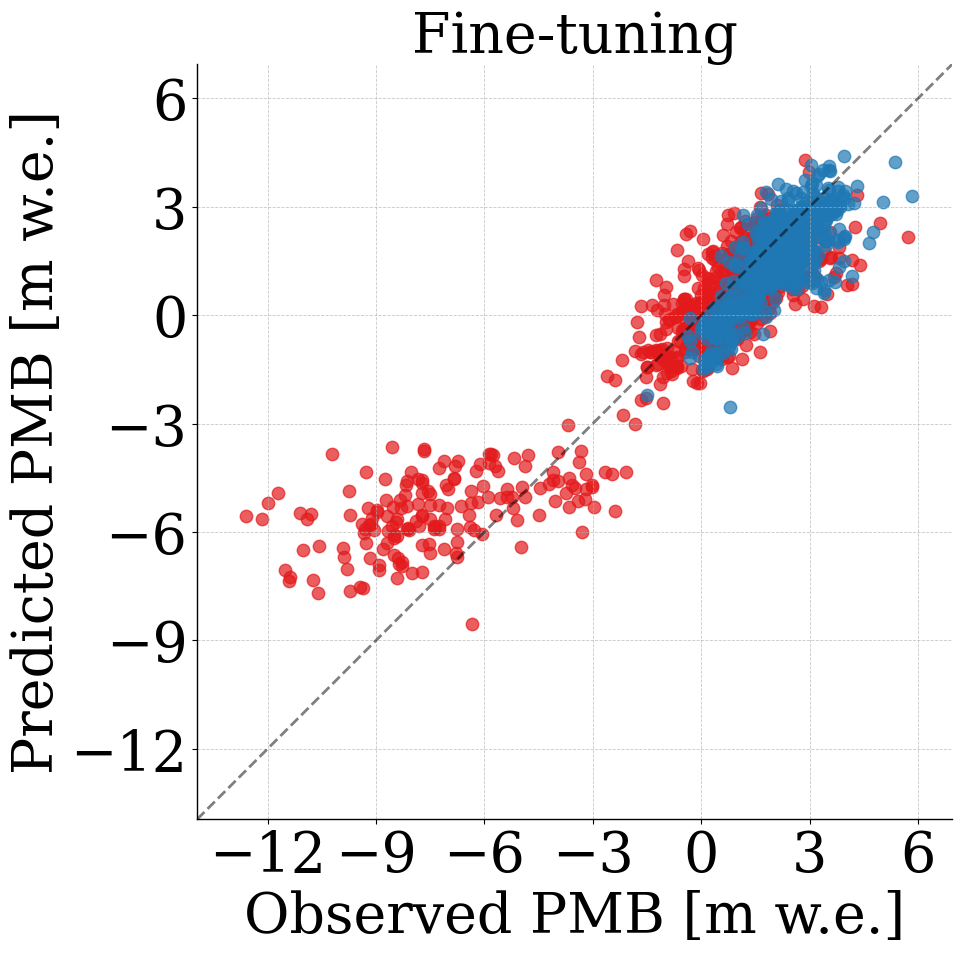


Loading and plotting: Swiss and Norwegian baseline, Nigardsbreen
Model file: nn_model_2025-09-07_50%_kmeans_CH_and_regional_baseline_only_NOR_val.pt


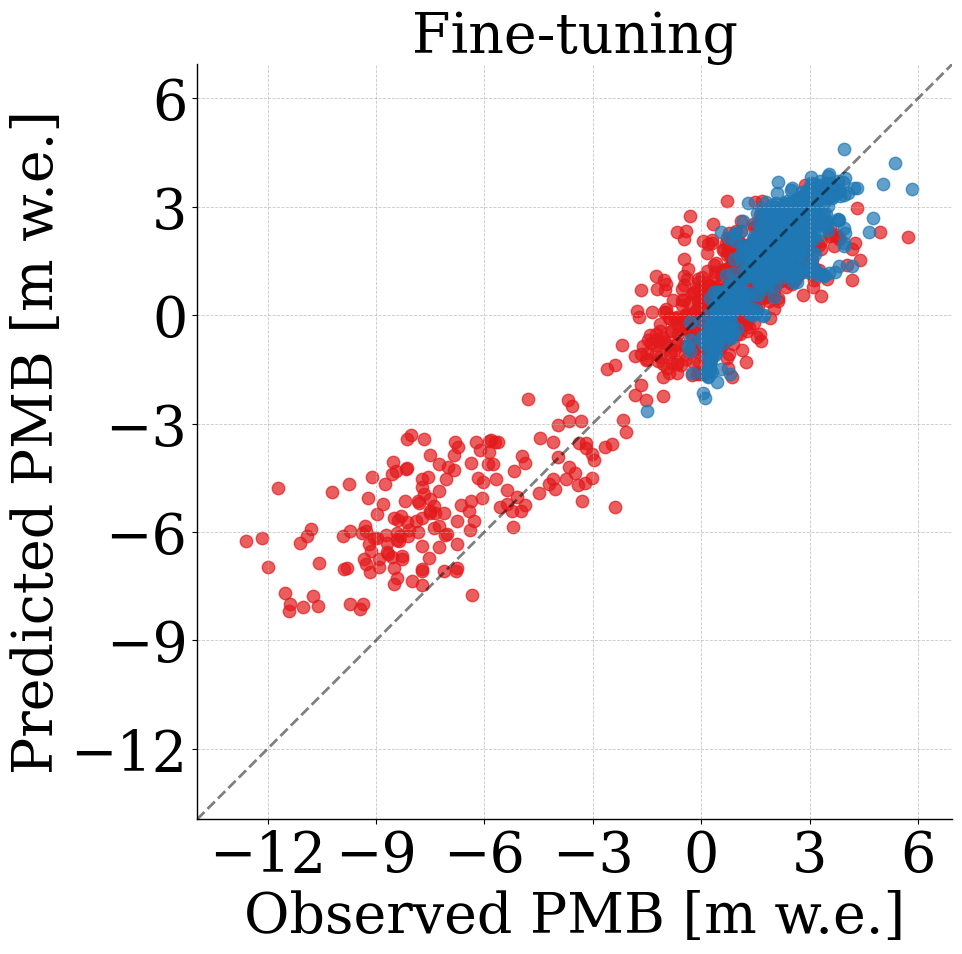


Loading and plotting: Fine-tuning, Nigardsbreen
Model file: nn_model_finetuned_2025-09-07_50%_kMeans_fine_tuning_lr0.00005_epoch_10.pt


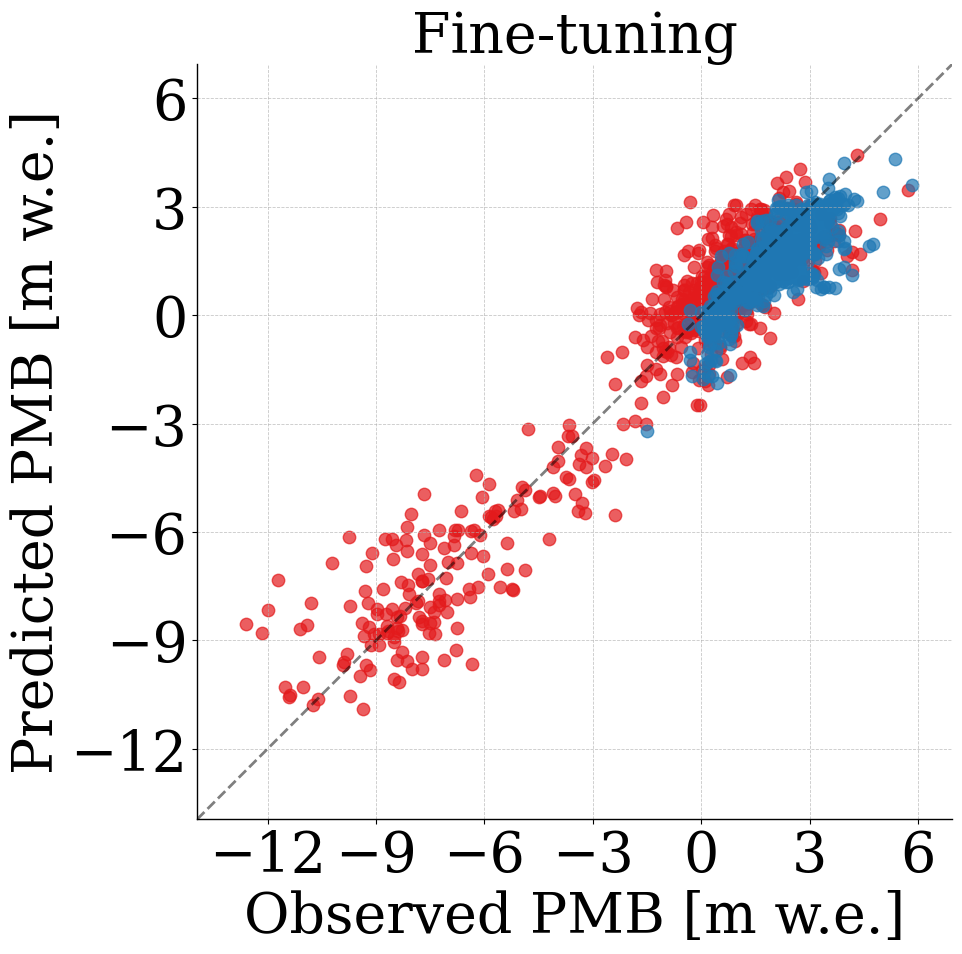


Loading and plotting: BatchNorm unfrozen, Nigardsbreen
Model file: nn_model_finetuned_2025-09-07_50%_kMeans_batchnorm_unfrozen_linear_frozen_lr0.1_epoch200.pt


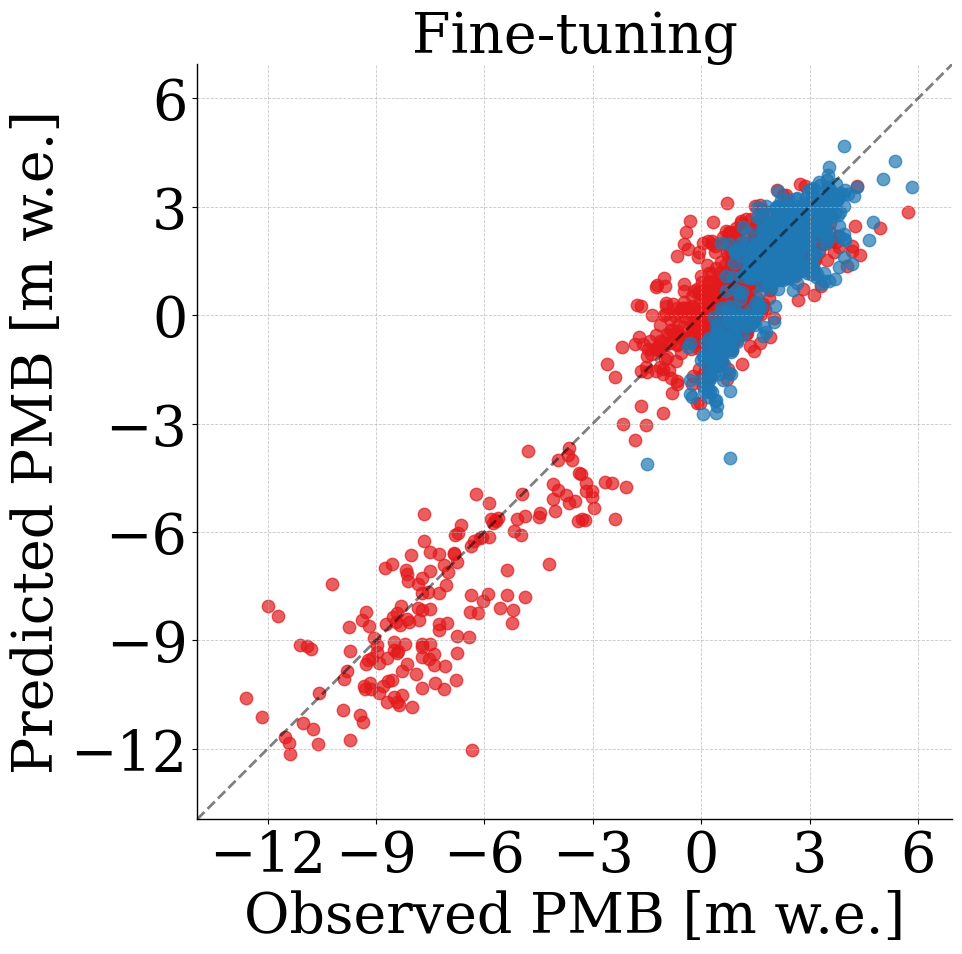


Loading and plotting: DANN, Nigardsbreen
Model file: dann_model_2025-09-07_50%_kMeans_lambda0_05_mean_domainloss_even_domainloss_only_NOR_val_50_50_epochsplit_epoch60.pt


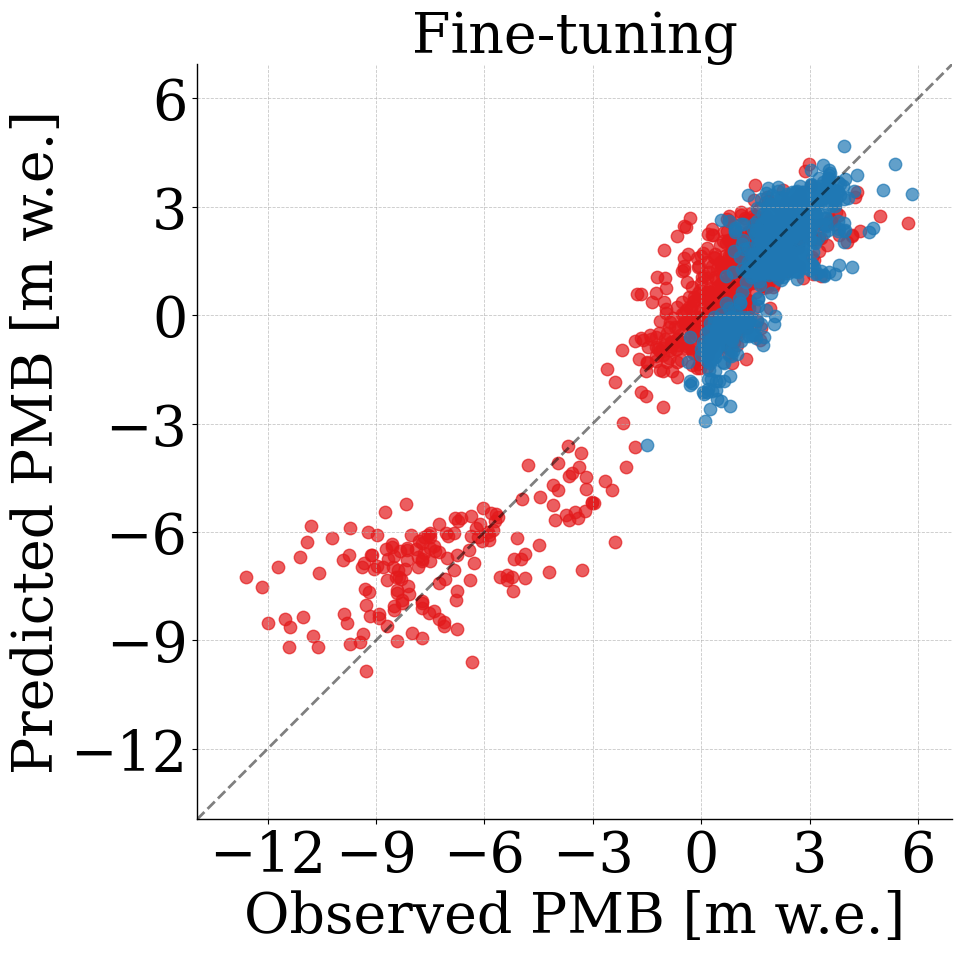

In [ ]:


# Build loader args for different model types
nn_loader_args = {**swiss_args, **param_init}
dann_loader_args = {
    **{
        **swiss_args,
        'module': DANNNetwork,
        'module__domain_hidden': 64,
        'module__grl_lambda': 1.0,
    },
    'dan_lambda': 0.01,
    **param_init,
}

# Base dataframe with targets and metadata (same for all models)
base = grouped_ids[['ID', 'target', 'PERIOD', 'GLACIER', 'YEAR']].copy()

# Select only Nigardsbreen
GLACIER_OF_INTEREST = 'Nigardsbreen'
base = base[base['GLACIER'] == GLACIER_OF_INTEREST].copy()

for label, fname, model_cls in models:
    print(f'\n{"="*50}')
    print(f'Loading and plotting: {label}, {GLACIER_OF_INTEREST}')
    print(f'Model file: {fname}')
    print(f'{"="*50}')
    
    # Load model with appropriate arguments
    if model_cls.__name__ == 'CustomDANNRegressor':
        mdl = model_cls.load_model(cfg, fname, **dann_loader_args)
    else:
        mdl = model_cls.load_model(cfg, fname, **nn_loader_args)
    
    mdl = mdl.set_params(device=device).to(device)
    
    # Make predictions for the full test dataset and then restrict to Nigardsbreen IDs
    y_pred_agg = mdl.aggrPredict(dataset_test[0])

    # Create grouped_ids dataframe for this model and filter to Nigardsbreen
    model_grouped_ids = base.copy()
    # `base` contains only Nigardsbreen rows; assume prediction order matches grouped_ids order.
    # If `y_pred_agg` corresponds to all test IDs, align by ID to be safe:
    preds_df = pd.DataFrame({'ID': dataset_test[0].dataset.indexToId(np.arange(len(y_pred_agg))), 'pred_full': y_pred_agg})
    # merge and keep only Nigardsbreen
    model_grouped_ids = model_grouped_ids.merge(preds_df, on='ID', how='left')
    model_grouped_ids['pred'] = model_grouped_ids['pred_full']
    model_grouped_ids = model_grouped_ids.drop(columns=['pred_full'])

    if model_grouped_ids['pred'].isna().all():
        print(f'Warning: no predictions matched Nigardsbreen for model {label}. Skipping plot.')
        continue

    # Plot only Nigardsbreen
    PlotPredictionsCombined_NN(model_grouped_ids, region_name=f"{label} - {GLACIER_OF_INTEREST}",
                               include_summer=False, nticks=8, min_val=-1, max_val=6)
    plt.show()